# Analysis of the differential values for the Covid example
- This notebook read the output of the Seurat find cluster method
- Displays it as FlowSets
- Analyses genes differential in the first state with pathway enrichment

Content from Paper Figure 3
---
Author: Markus Joppich

In [1]:
# Enable autoreload for development (reloads modules before executing code)
%load_ext autoreload

# Set up Python path to include parent directory for local imports
import os, sys

# Automatically reload modules before executing code
%autoreload 2
from flowsets import *

# Import polars for fast DataFrame operations
import polars as pl

# Set matplotlib to produce high-resolution figures
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
# Check polars version for compatibility
pl.__version__

'1.19.0'

In [3]:
# Utility function to download and unzip a file if not present
# Used to fetch ReactomePathways.gmt if missing

def download_and_unzip(download_url_link, dir_path, zipped_filename, destination_dir_name):
    # https://www.tutorialsbuddy.com/download-and-unzip-a-zipped-file-in-python
    print("Download starting")
    urllib.request.urlretrieve(
        download_url_link, os.path.join(dir_path, zipped_filename)
    )
    print("Download complete")

    print("unzipping file starting")
    with zipfile.ZipFile(os.path.join(dir_path, zipped_filename), "r") as zip_file:
        zip_file.extractall(os.path.join(dir_path, destination_dir_name))
    print("unzipping complete")

# Download ReactomePathways.gmt if not already present
if not os.path.exists("ReactomePathways.gmt"):
    download_and_unzip("https://reactome.org/download/current/ReactomePathways.gmt.zip", ".", "ReactomePathways.gmt.zip", ".")

In [4]:
# Load and filter single-cell COVID-19 differential expression data
# Only keep genes with adjusted p-value < 0.05
exprData = pl.read_csv("sccovid_data/de_comparison_monocytes_combined_results.tsv", has_header=True, separator="\t", null_values=["NA"])
exprData = exprData.filter( pl.col("p_val_adj") < 0.05)
print(exprData)

# Uncomment to inspect unique clusters
# print(exprData.select("cluster").unique())

shape: (349, 25)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ gene       ┆ p_val      ┆ avg_log2FC ┆ pct.1 ┆ … ┆ mean.cell ┆ sd.cells_ ┆ count_all ┆ cluster   │
│ ---        ┆ ---        ┆ ---        ┆ ---   ┆   ┆ s_asympt  ┆ asympt    ┆ .cells_as ┆ ---       │
│ str        ┆ f64        ┆ f64        ┆ f64   ┆   ┆ ---       ┆ ---       ┆ ympt      ┆ str       │
│            ┆            ┆            ┆       ┆   ┆ f64       ┆ f64       ┆ ---       ┆           │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆ i64       ┆           │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ABCA1      ┆ 6.8714e-40 ┆ 0.635767   ┆ 0.523 ┆ … ┆ 0.868175  ┆ 0.334164  ┆ 131       ┆ cluster.t │
│            ┆            ┆            ┆       ┆   ┆           ┆           ┆           ┆ p01       │
│ ABHD17C    ┆ 4.2551e-14 ┆ 0.26367    ┆ 0.246 ┆ … ┆ 0.757996  ┆ 0.160108 

In [5]:
# Check the type of exprData (should be a polars DataFrame)
type(exprData)

polars.dataframe.frame.DataFrame

In [6]:
# Filter for a specific gene (e.g., IFI44L) to inspect its results
exprData.filter(pl.col("gene") == "IFI44L")

shape: (2, 25)
┌────────┬────────────┬────────────┬───────┬───┬────────────┬────────────┬────────────┬────────────┐
│ gene   ┆ p_val      ┆ avg_log2FC ┆ pct.1 ┆ … ┆ mean.cells ┆ sd.cells_a ┆ count_all. ┆ cluster    │
│ ---    ┆ ---        ┆ ---        ┆ ---   ┆   ┆ _asympt    ┆ sympt      ┆ cells_asym ┆ ---        │
│ str    ┆ f64        ┆ f64        ┆ f64   ┆   ┆ ---        ┆ ---        ┆ pt         ┆ str        │
│        ┆            ┆            ┆       ┆   ┆ f64        ┆ f64        ┆ ---        ┆            │
│        ┆            ┆            ┆       ┆   ┆            ┆            ┆ i64        ┆            │
╞════════╪════════════╪════════════╪═══════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ IFI44L ┆ 8.0165e-8  ┆ -0.284868  ┆ 0.681 ┆ … ┆ 1.985736   ┆ 0.470494   ┆ 131        ┆ cluster.tp │
│        ┆            ┆            ┆       ┆   ┆            ┆            ┆            ┆ 01         │
│ IFI44L ┆ 3.0653e-10 ┆ -0.388165  ┆ 0.359 ┆ … ┆ 1.627667   ┆ 0.56889    ┆ 208        ┆ cluster.tp │
│        ┆            ┆            ┆       ┆   ┆            ┆            ┆            ┆ 02         │
└────────┴────────────┴────────────┴───────┴───┴────────────┴────────────┴────────────┴────────────┘

In [7]:
# Initialize the legacy fuzzifier for fuzzy logic transformation
lfz = LegacyFuzzifier()

In [8]:
# Confirm exprData type again after filtering
type(exprData)

polars.dataframe.frame.DataFrame

centers [-1.  -0.5  0.   0.5  1. ]
Creating Universe Range -1.0 -> 1.0 with step size 0.1
Mean Expr avg_log2FC col 2
Expr Count pct.1 col 3
SD None col None
Cluster cluster col 24
Combining over state:  False
to_homogeneous: cluster.tp03
to_homogeneous: cluster.tp01
to_homogeneous: cluster.tp02


shape: (314, 16)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ gene   ┆ ASYMPT.clu ┆ asympt.clu ┆ nodiff.cl ┆ … ┆ asympt.cl ┆ nodiff.cl ┆ sympt.clu ┆ SYMPT.clu │
│ ---    ┆ ster.tp03  ┆ ster.tp03  ┆ uster.tp0 ┆   ┆ uster.tp0 ┆ uster.tp0 ┆ ster.tp02 ┆ ster.tp02 │
│ str    ┆ ---        ┆ ---        ┆ 3         ┆   ┆ 2         ┆ 2         ┆ ---       ┆ ---       │
│        ┆ f64        ┆ f64        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│        ┆            ┆            ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆           │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ CDKN1C ┆ 0.0        ┆ 3.4683e-16 ┆ 0.801505  ┆ … ┆ 4.4409e-1 ┆ 1.0       ┆ 4.4409e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆ 6         ┆           ┆ 6         ┆           │
│ CFD    ┆ 0.0        ┆ 6.7502e-17 ┆ 0.27545   ┆ … ┆ 4.9294e-1 ┆ 0.455314  ┆ 0.544686  ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆ 7         ┆           ┆           ┆           │
│ DDX3Y  ┆ 0.096877   ┆ 0.152123   ┆ 0.751     ┆ … ┆ 0.186411  ┆ 0.813589  ┆ 2.9310e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆           ┆           ┆ 6         ┆           │
│ GNLY   ┆ 0.0        ┆ 2.9887e-16 ┆ 0.767267  ┆ … ┆ 4.4409e-1 ┆ 1.0       ┆ 4.4409e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆ 6         ┆           ┆ 6         ┆           │
│ IGKC   ┆ 0.0        ┆ 2.1938e-16 ┆ 0.564386  ┆ … ┆ 4.4409e-1 ┆ 1.0       ┆ 4.4409e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆ 6         ┆           ┆ 6         ┆           │
│ …      ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ TPM4   ┆ 0.0        ┆ 4.4409e-16 ┆ 1.0       ┆ … ┆ 0.486363  ┆ 0.513637  ┆ 8.3489e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆           ┆           ┆ 7         ┆           │
│ TXNIP  ┆ 0.0        ┆ 4.4409e-16 ┆ 1.0       ┆ … ┆ 3.4639e-1 ┆ 0.15218   ┆ 0.84782   ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆ 7         ┆           ┆           ┆           │
│ UBE2J1 ┆ 0.0        ┆ 4.4409e-16 ┆ 1.0       ┆ … ┆ 0.278866  ┆ 0.721133  ┆ 2.0917e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆           ┆           ┆ 6         ┆           │
│ VAPA   ┆ 0.0        ┆ 4.4409e-16 ┆ 1.0       ┆ … ┆ 0.409209  ┆ 0.590791  ┆ 8.0824e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆           ┆           ┆ 7         ┆           │
│ ZNF331 ┆ 0.0        ┆ 4.4409e-16 ┆ 1.0       ┆ … ┆ 0.118603  ┆ 0.712     ┆ 3.1619e-1 ┆ 0.0       │
│        ┆            ┆            ┆           ┆   ┆           ┆           ┆ 6         ┆           │
└────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

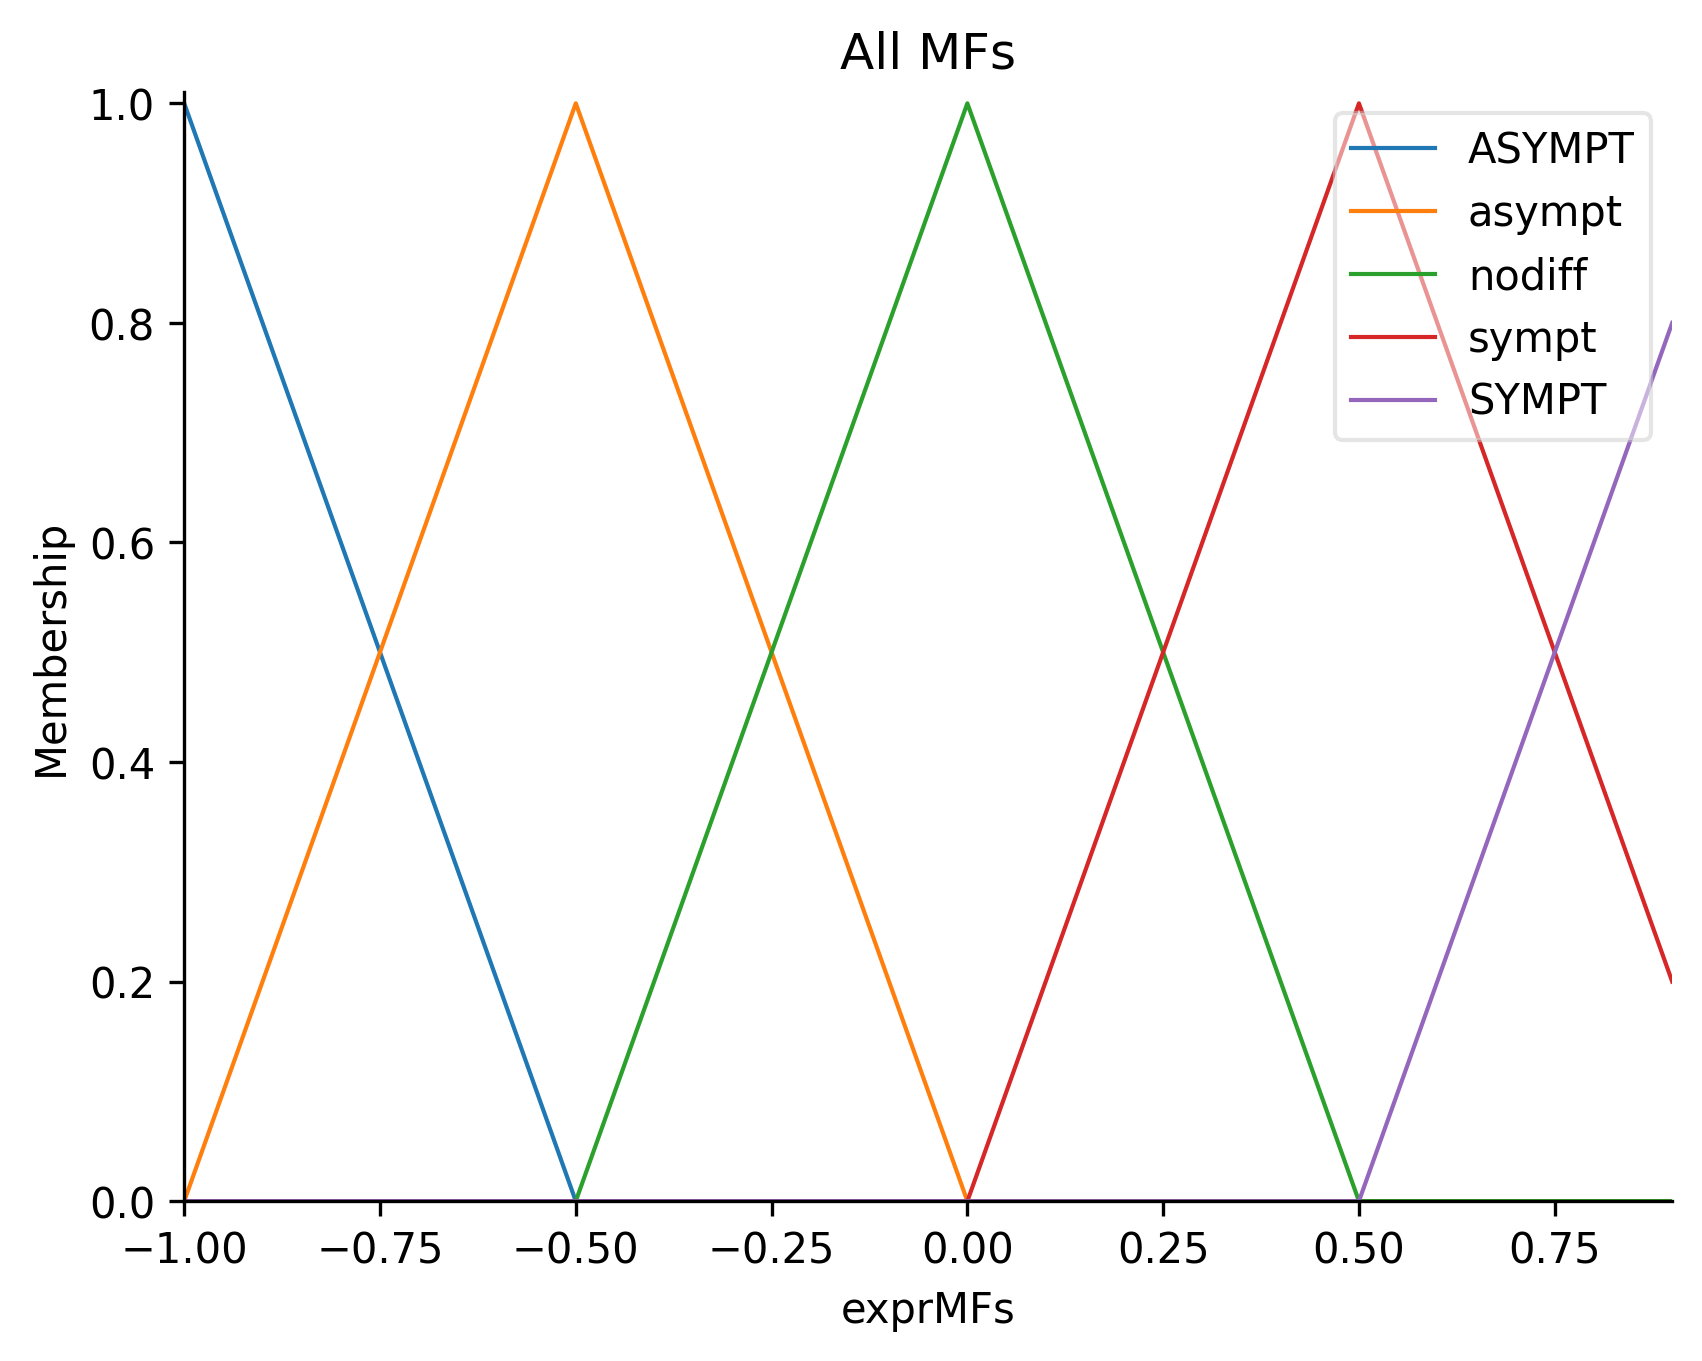

In [9]:
# Fuzzify the expression data using LegacyFuzzifier
# This transforms log2FC values into fuzzy membership scores for each state
explDFWide, mfFuzzy = LegacyFuzzifier.fuzzify(
    exprData, stepsize=0.1, 
    seriesOrder=["cluster.tp01","cluster.tp02","cluster.tp03"],
    mfLevels = ["ASYMPT", "asympt", "nodiff", "sympt", "SYMPT"],
    centerMode="minmax",
    meancolName="avg_log2FC", sdcolName=None, exprcolName="pct.1", mfLevelsMirrored=True
)
explDFWide

In [10]:
# Optionally set pandas display options for debugging
# pd.set_option("display.max_rows", 200, "display.max_columns", 15)

In [11]:
# Define lists of interferon-stimulated genes (ISGs) for downstream analysis
isgListLong = ("MX1","MX2","MT2A","RSAD2","SIGLEC1","IFIT1","IFI44","IFI27","IFITM10","IFIT3","IFI6","IFIT1P1","IFIT2","IFITM9P","IFI30","IFITM3","IFI44L","IFIT1B","IFITM5","IFITM3P2","IFITM3P9","IFI27L2","IFIT5","IFITM1","IFIH1","IFI16","IFI35","IFI27L1","IRF6","IRF7","IRF9","IRF5","IRF4","IRF2BP2","IRF2BPL","IRF3","IRF1-AS1","ISG15","ISG20L2","ISG20","XAF1","LY6E","IFITM2","IFITM3P6","IFITM3P3","IFIT6P","IRF2BP1","IRF5P1","IRF2","IRF1","IRF8","IFITM3P7","IFITM4P","IFITM3P1","IFITM3P8")
isgListShort = ("MT2A", "ISG15", "LY6E", "IFIT1", "IFIT2", "IFIT3", "IFITM1", "IFITM3", "IFI44L", "IFI6", "MX1", "IFI27",  "IFI44L", "RSAD2", "SIGLEC1", "IFIT1", "ISG15")

In [12]:
# ...existing code...

In [13]:
# Create a FlowAnalysis object for the fuzzified data
# Map cluster timepoints to display names
fa = FlowAnalysis(
    explDFWide, "gene", 
    (  ("tp01", "TP 1"),("tp02", "TP 2"),("tp03", "TP 3")), 
    mfFuzzy, sep=".cluster."
)

In [14]:
fa.flows.shape

(314, 16)

/home/o/offensperger/.local/lib/python3.12/site-packages/flowsets/flowsets.py:1643: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtickLabels)


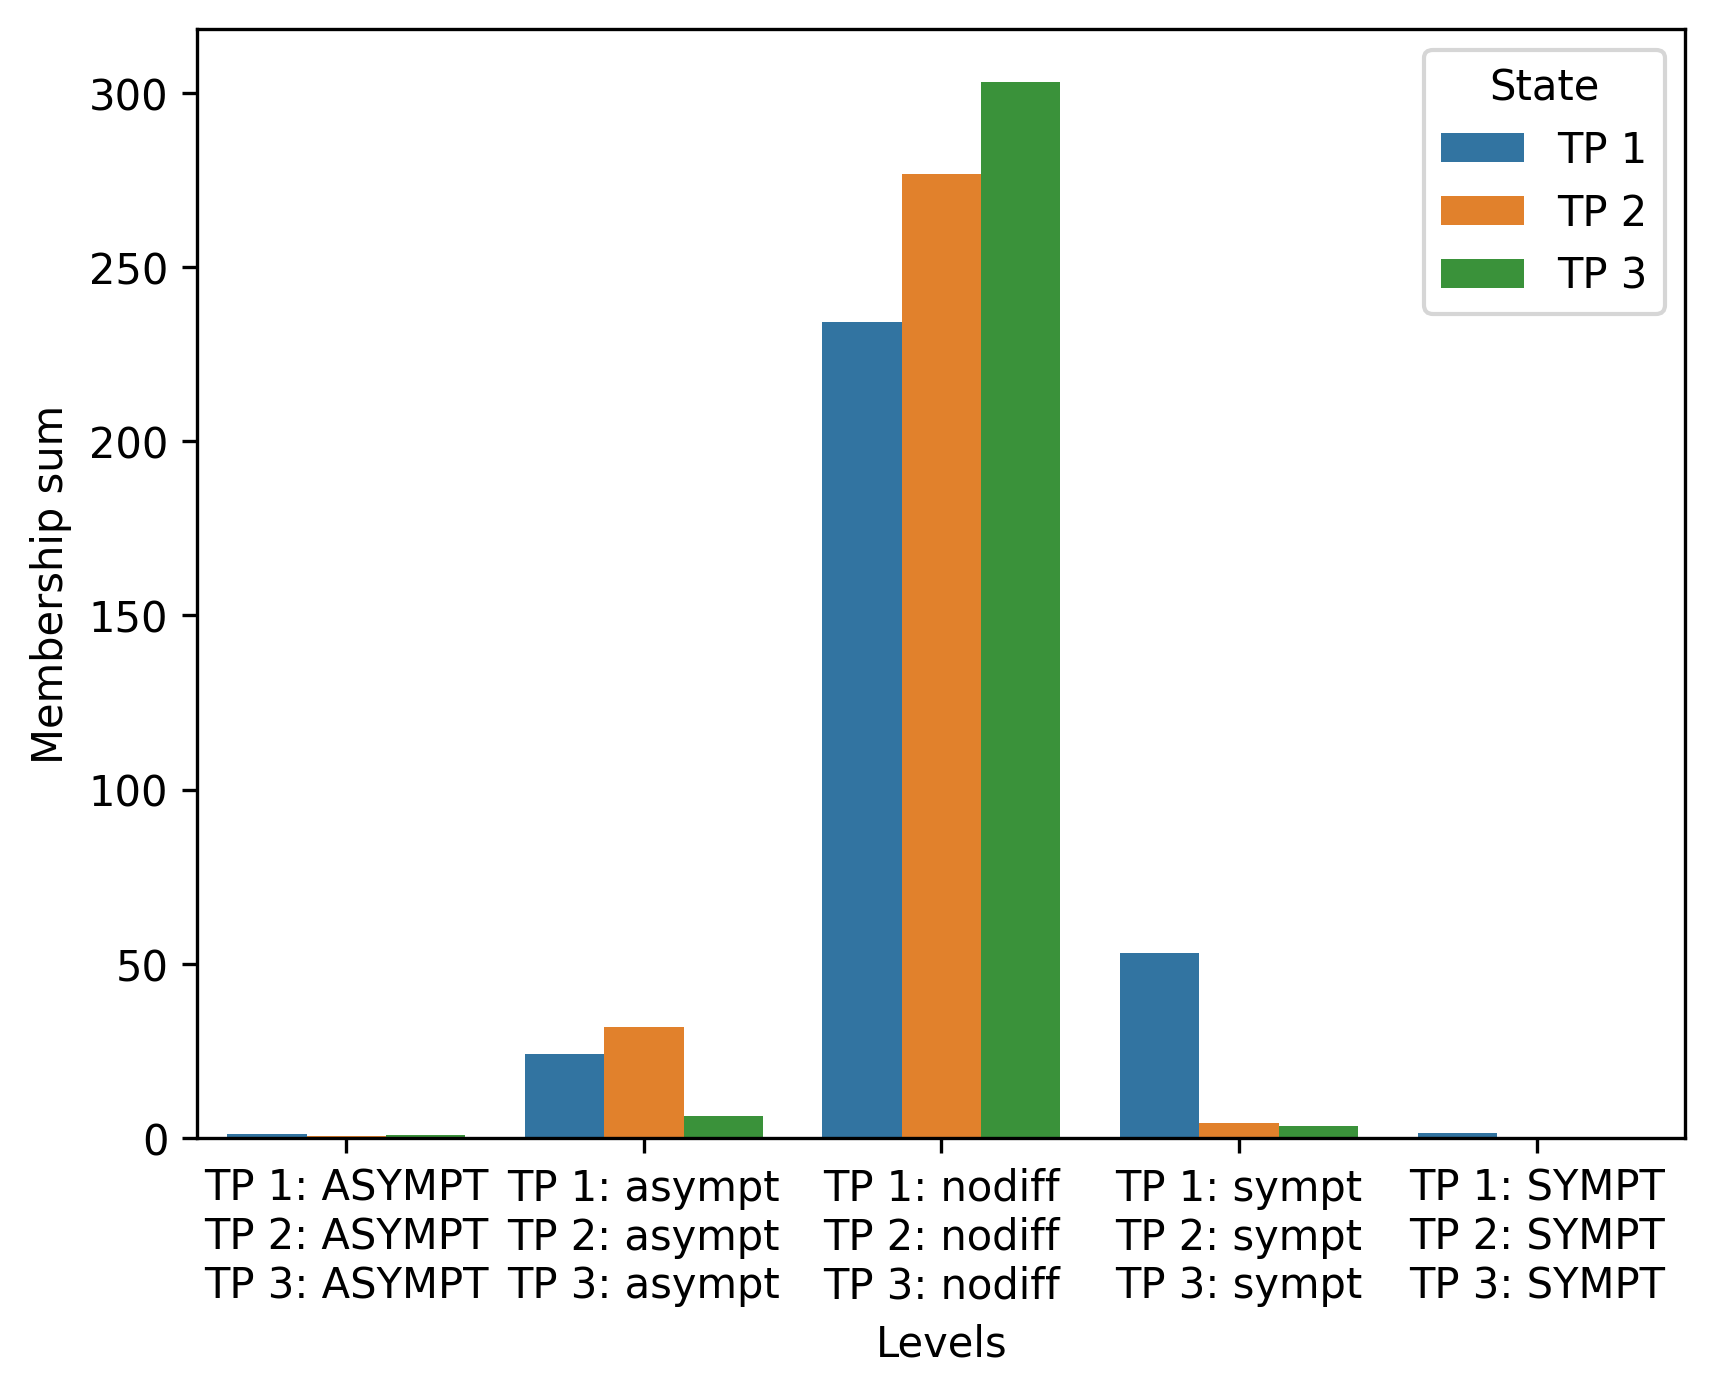

In [15]:
# Plot histogram of total membership for each fuzzy level
fa.hist_level_membershipsum()

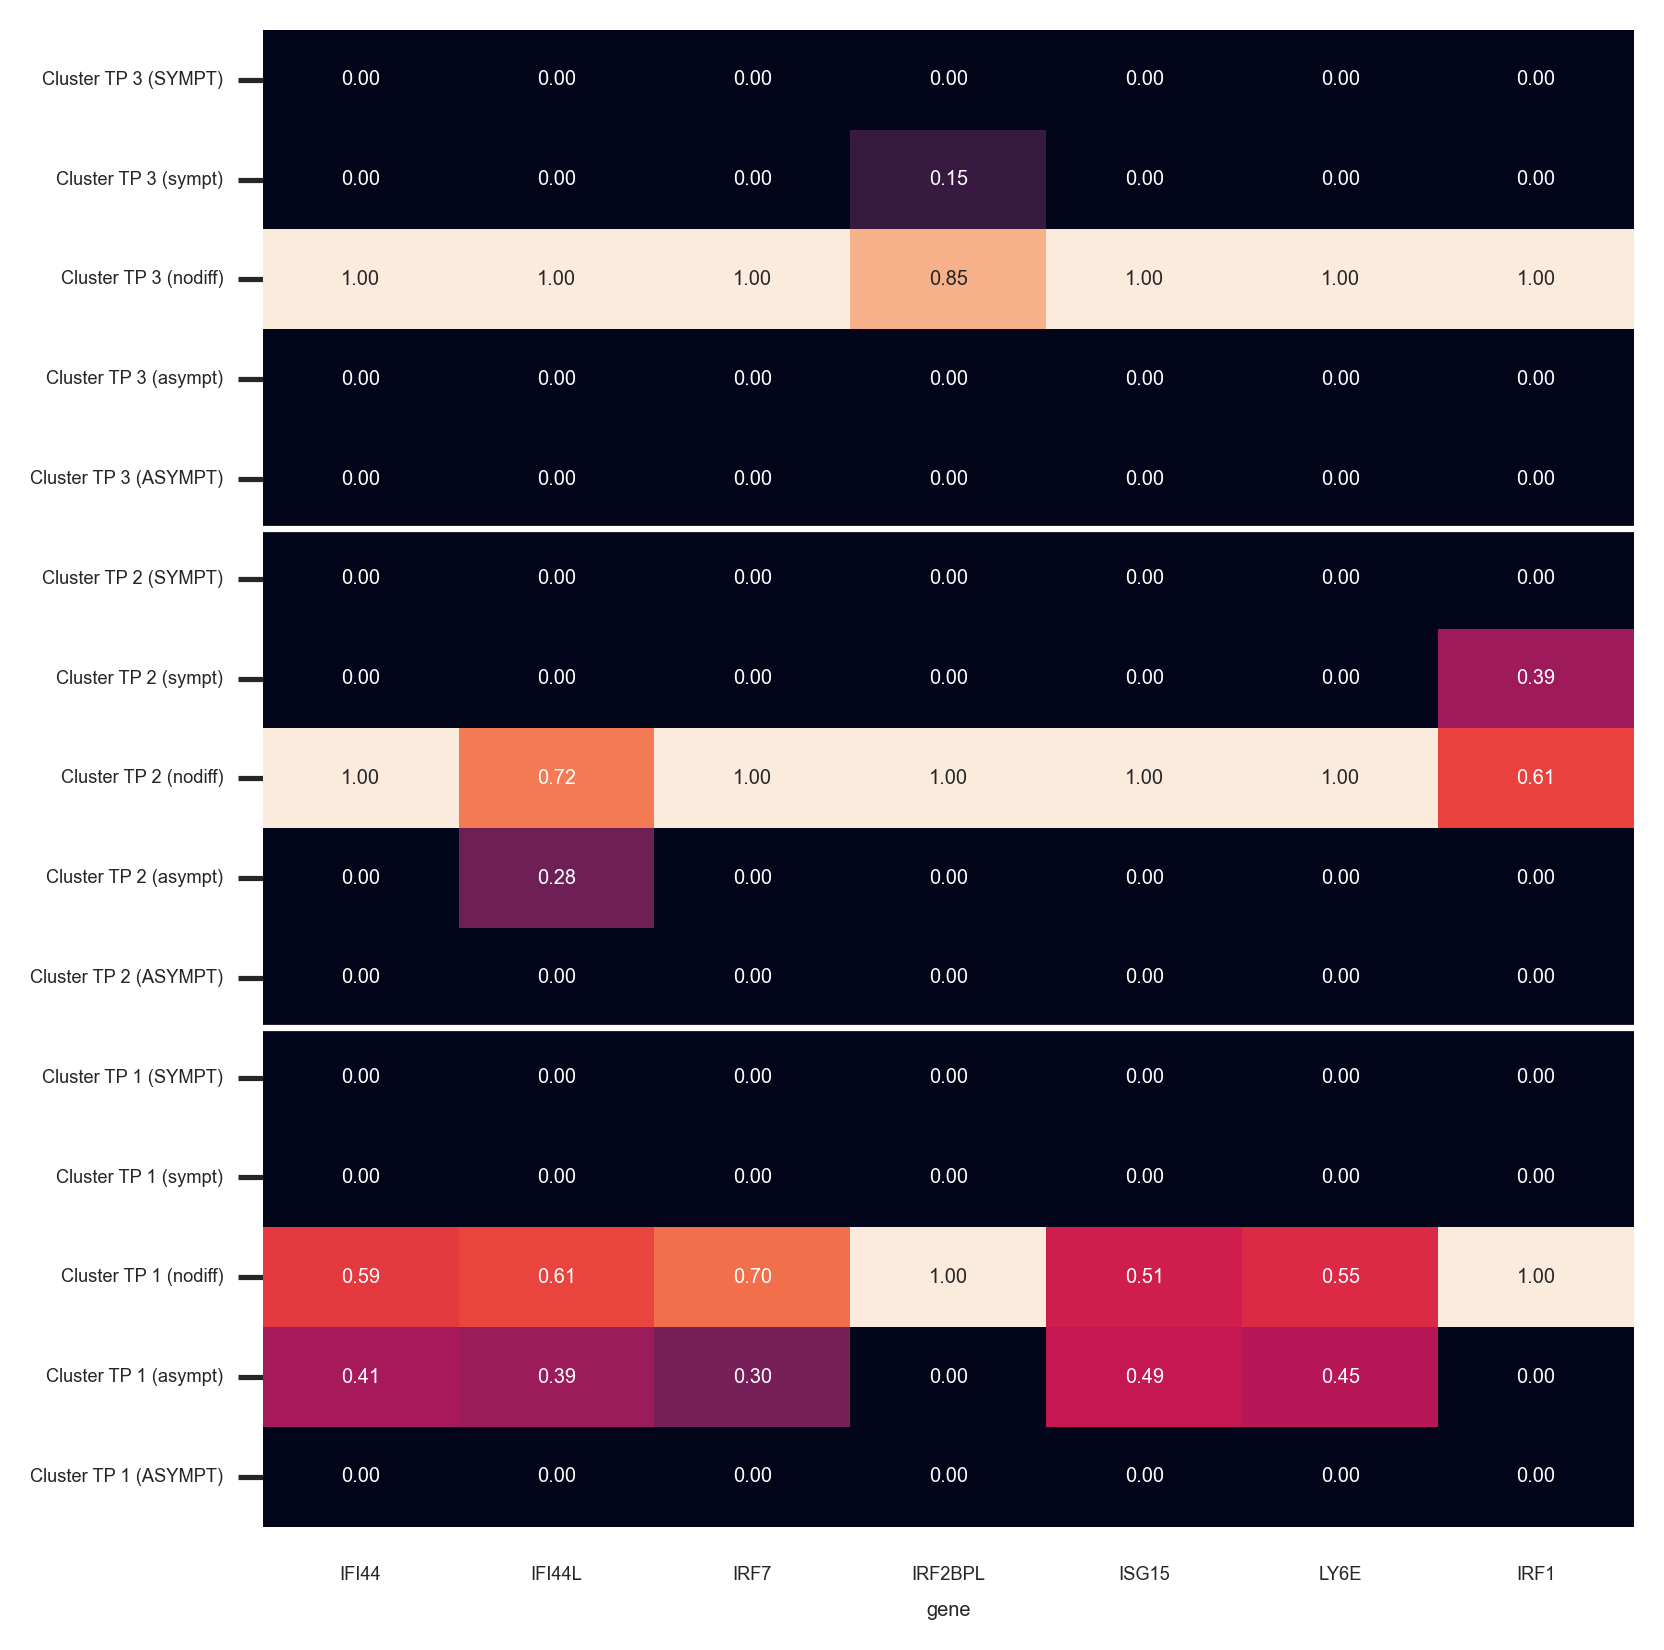

In [16]:
# Plot state memberships for the long ISG list
_ = fa.plot_state_memberships(isgListLong, verbose=False)

In [17]:
# Create a color map for plotting flows by state
import seaborn as sns

scm = fa._create_series_color_map(None, "scaling")
icefires = sns.color_palette("icefire", len(scm)+2)

sc = {x: scm[x](1.0) for xi, x in enumerate(scm)}
# Alternative: assign colors from icefire palette
# sc = {x: icefires[xi+1] for xi, x in enumerate(scm)}
sc

{'TP 1': (np.float64(0.267004),
  np.float64(0.004874),
  np.float64(0.329415),
  np.float64(1.0)),
 'TP 2': (np.float64(0.190631),
  np.float64(0.407061),
  np.float64(0.556089),
  np.float64(1.0)),
 'TP 3': (np.float64(0.20803),
  np.float64(0.718701),
  np.float64(0.472873),
  np.float64(1.0))}

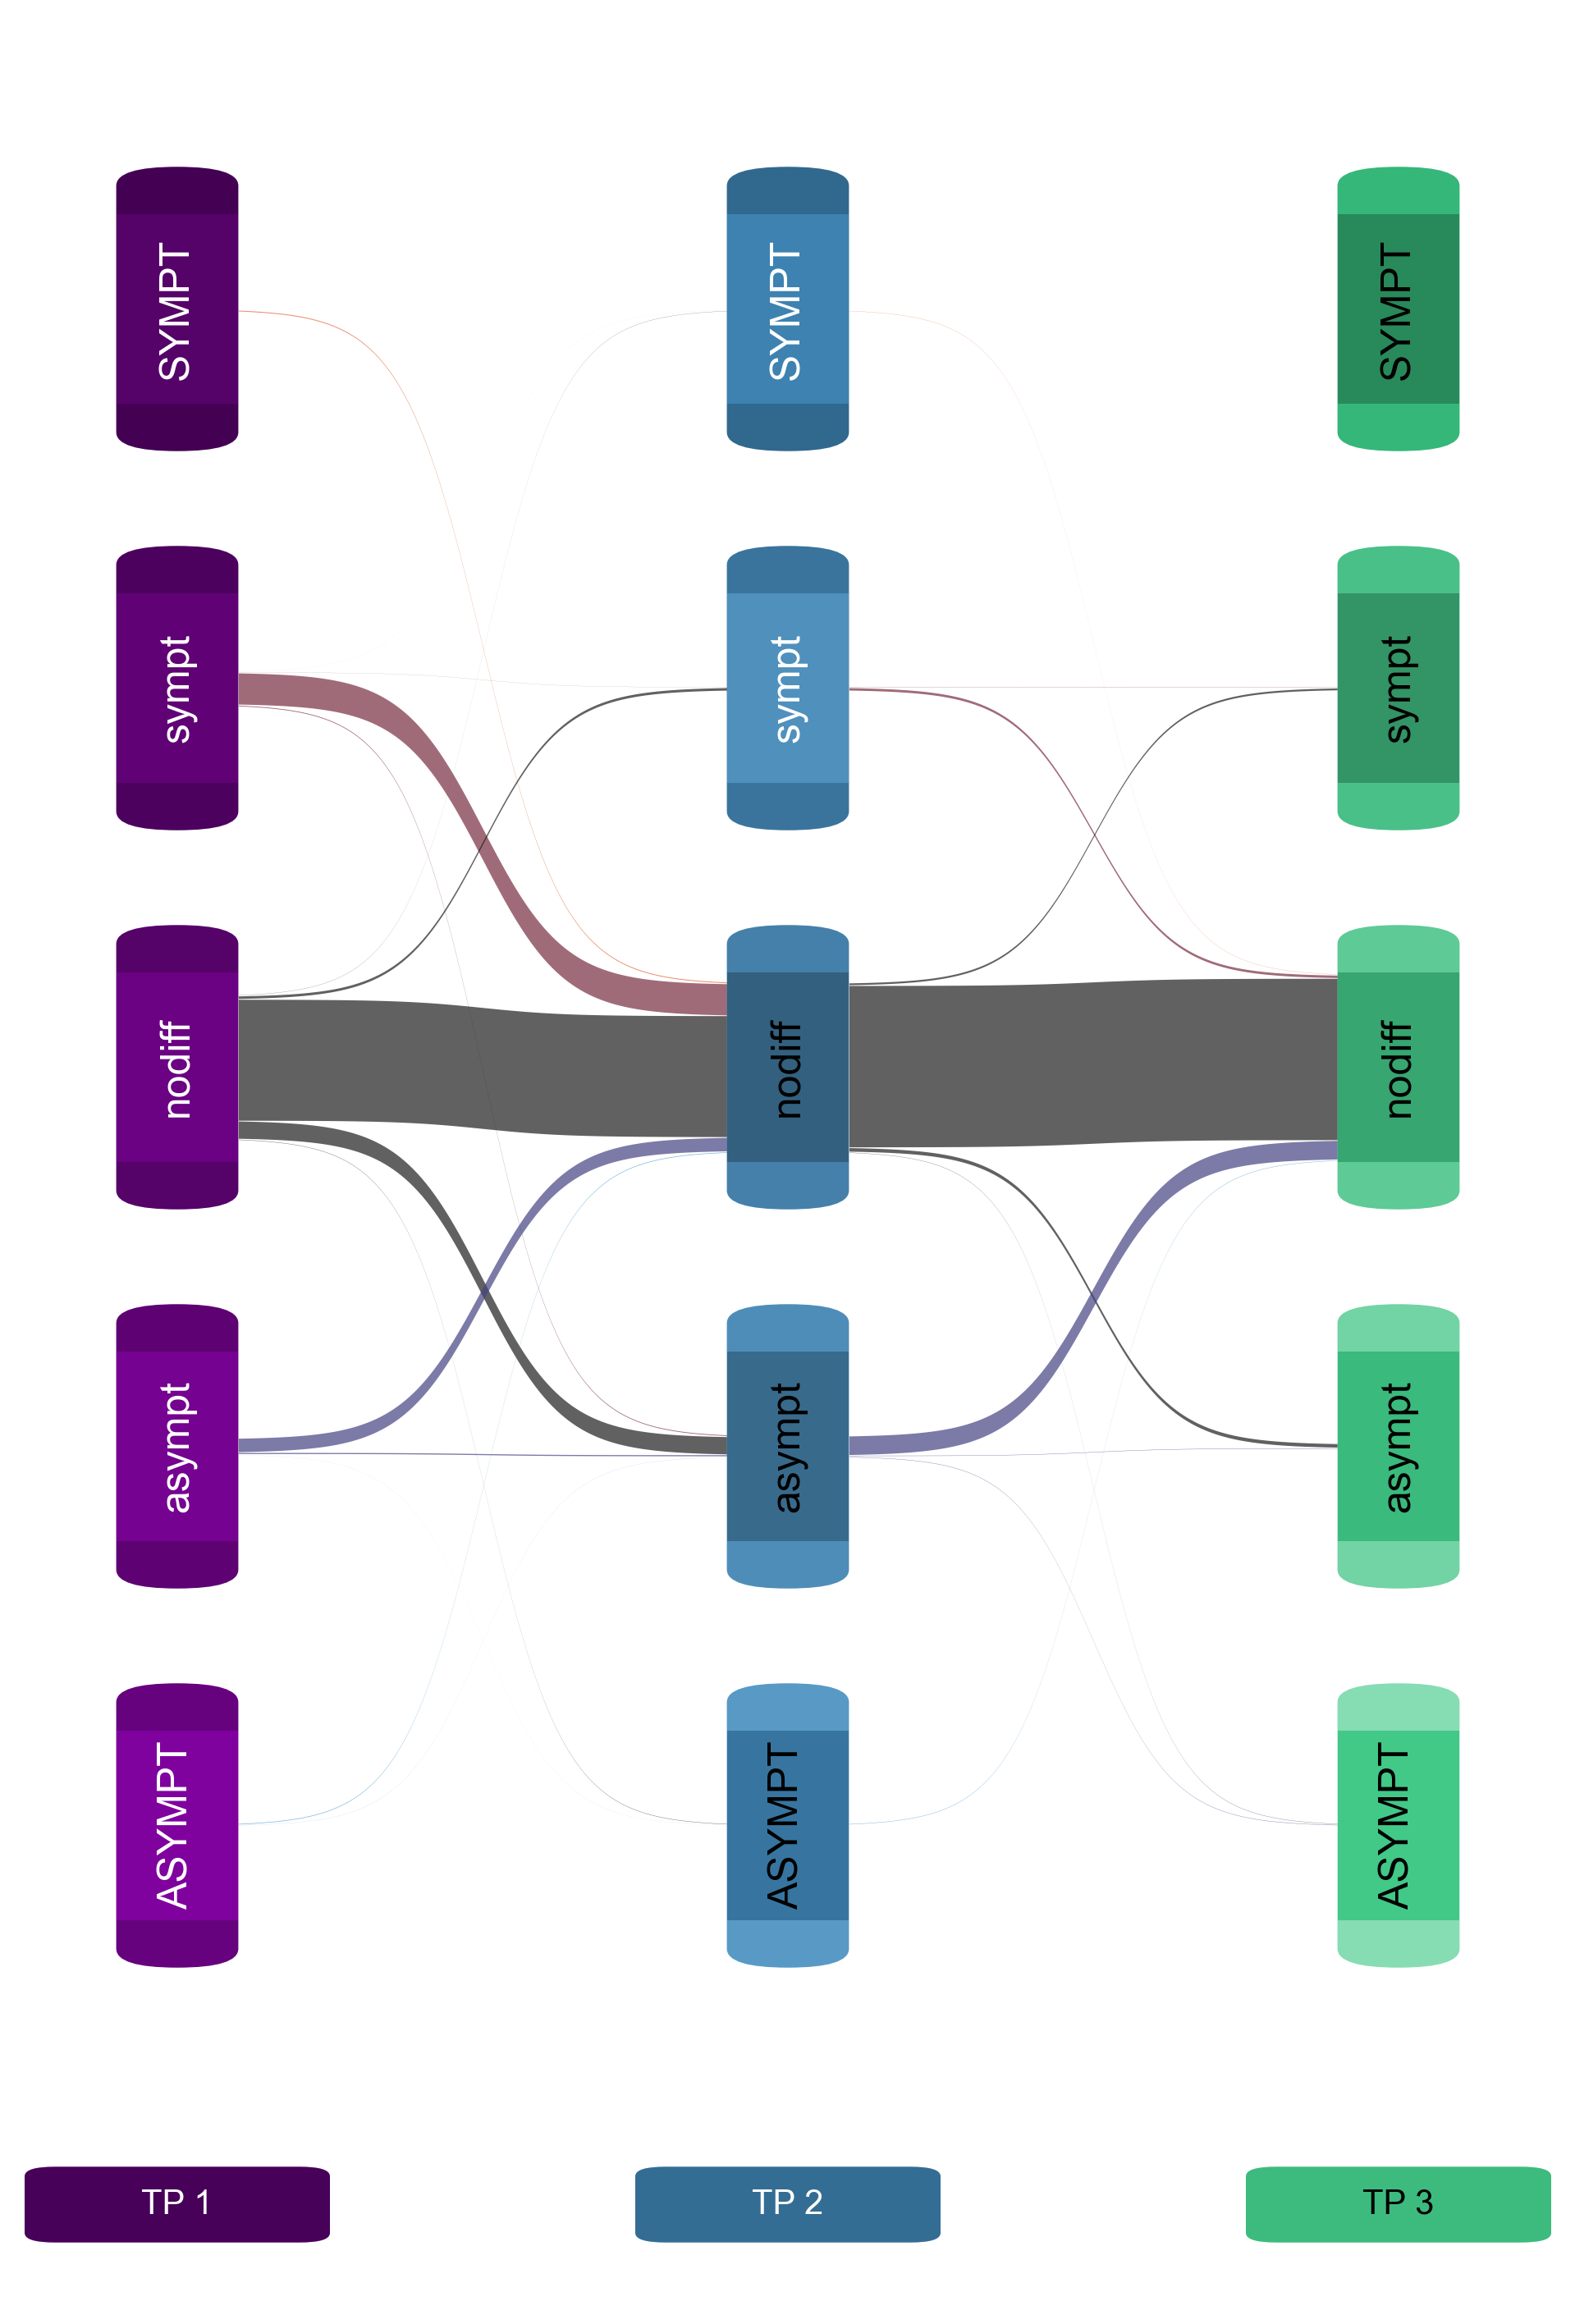

In [18]:
# Plot all flows with custom colors and save to file
fa.plot_flows(verbose=False, seriesColors=sc, figsize=(8,12), outfile="plots/ddiff_flows_all")

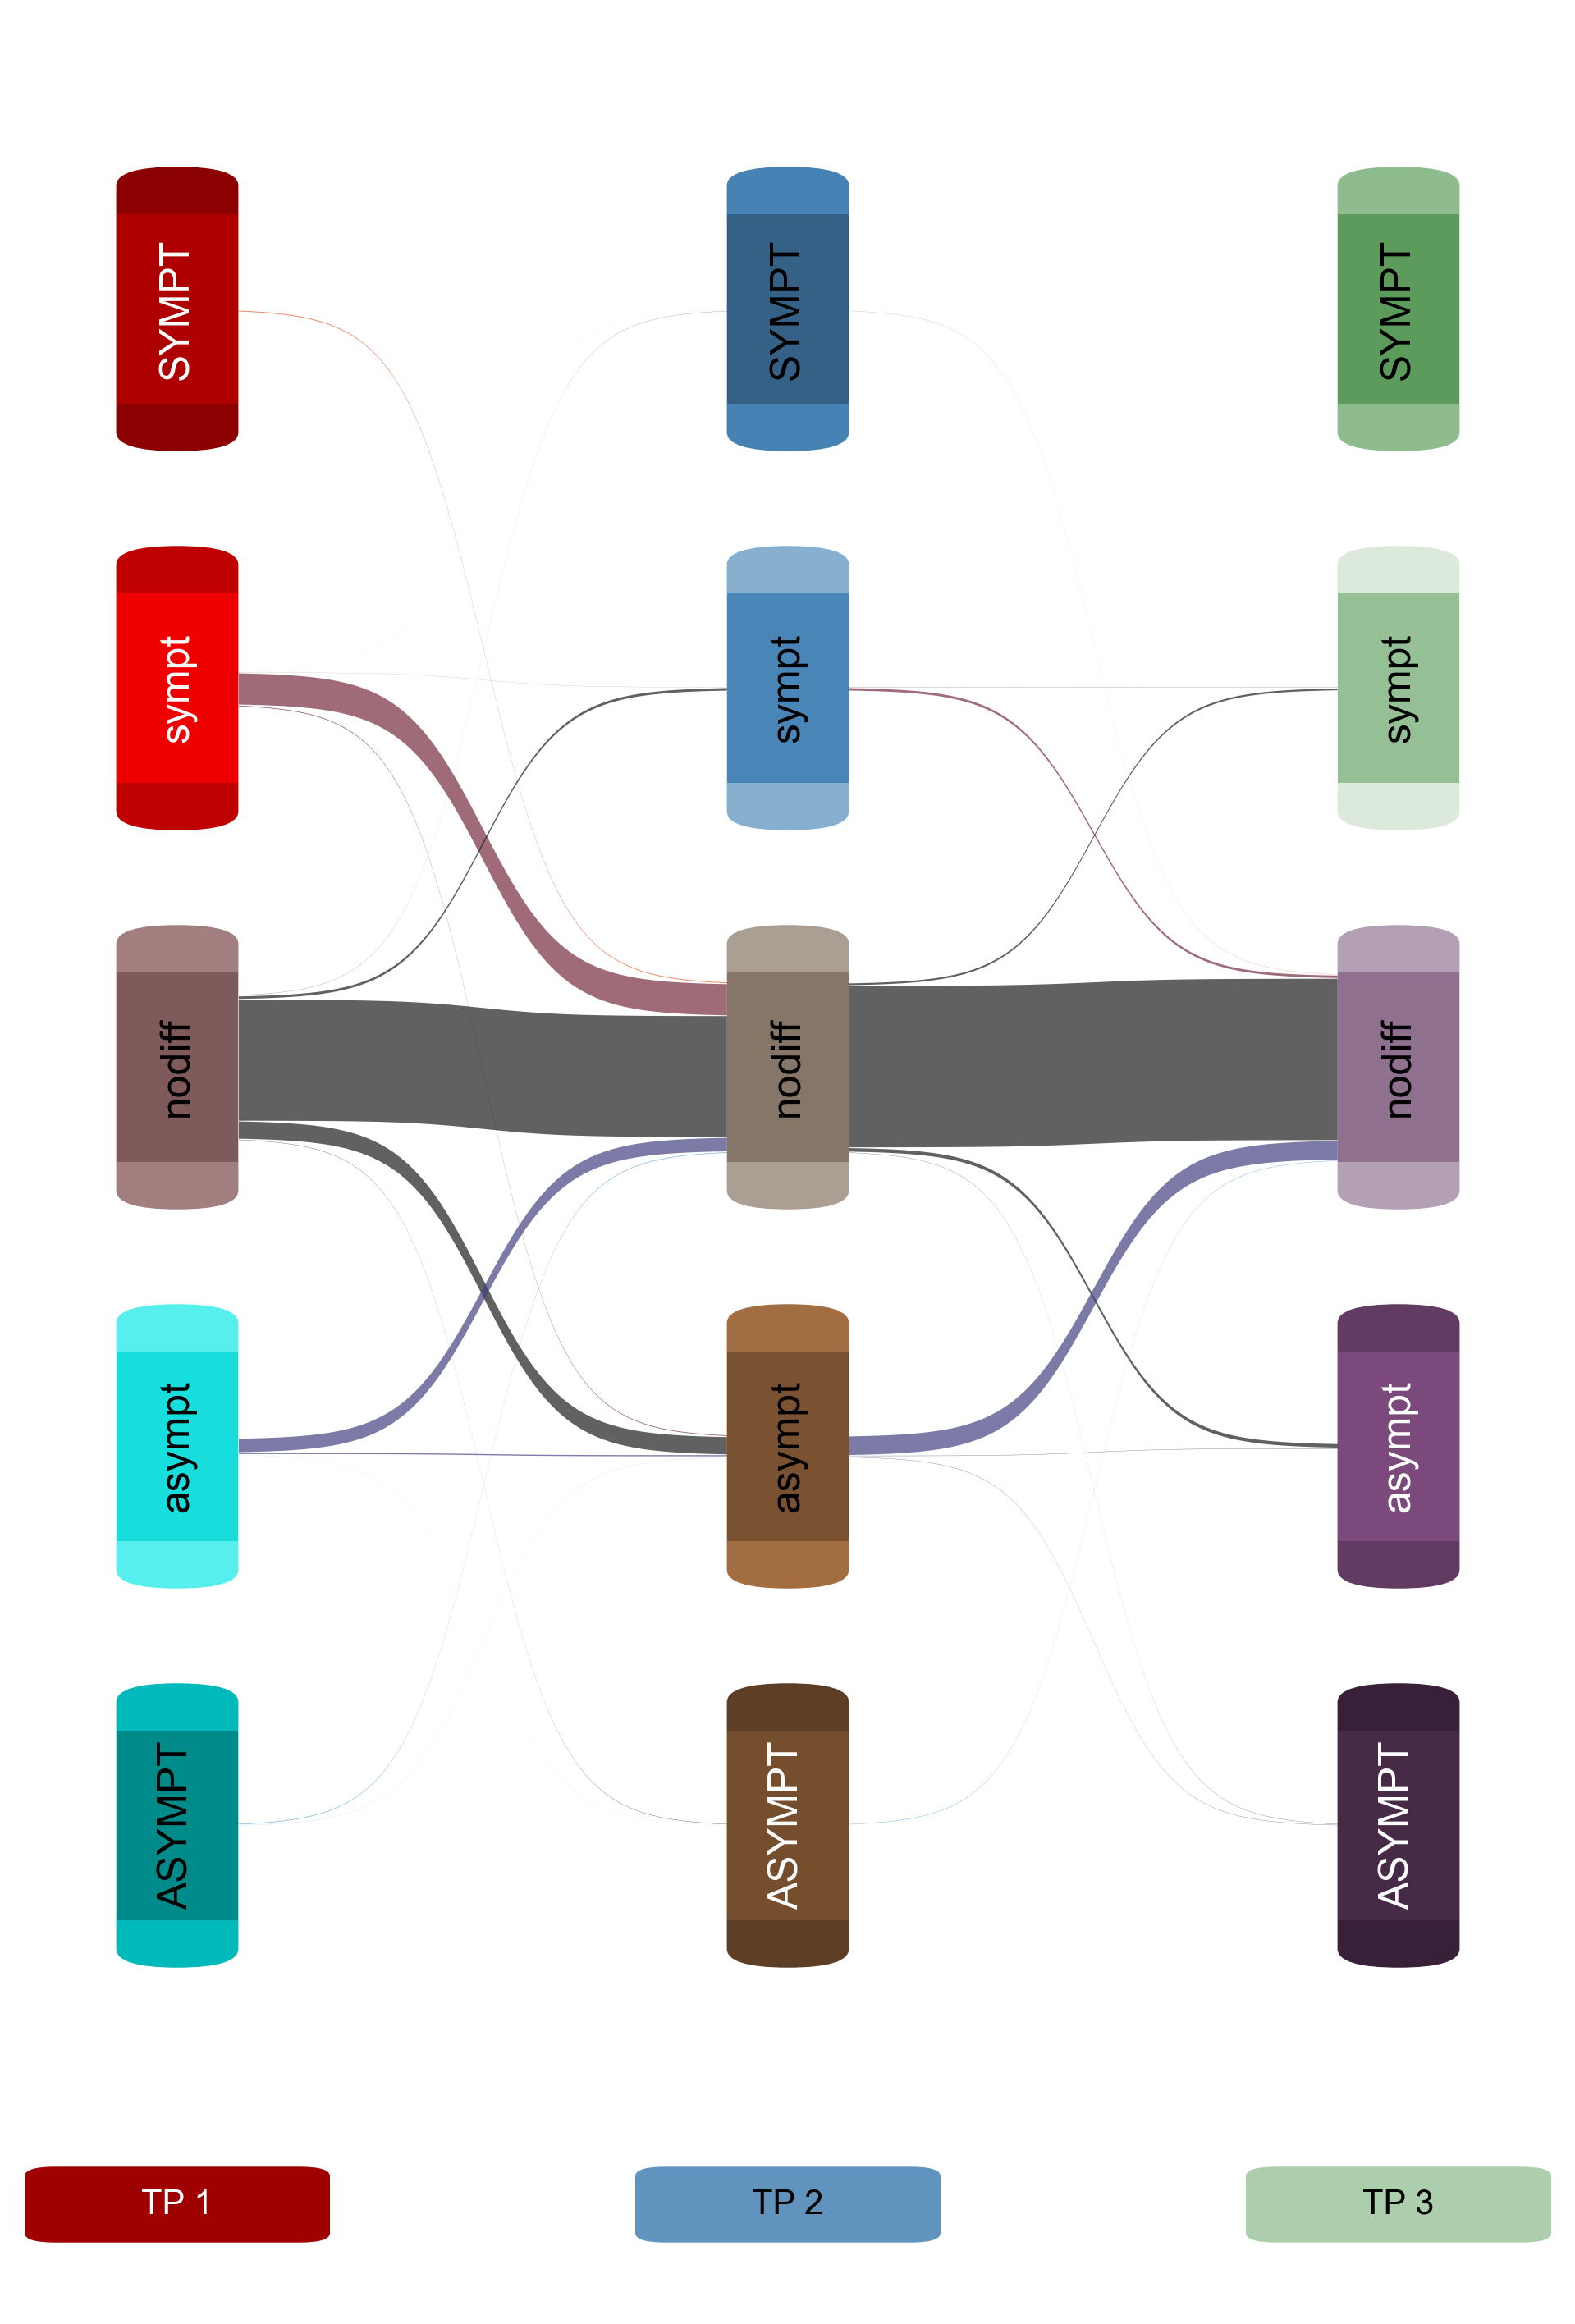

In [19]:
# Plot all flows with manually specified diverging colors
fa.plot_flows(figsize=(8,12), verbose=False, seriesColors={"TP 1": "darkred", "TP 2": "steelblue", "TP 3": "darkseagreen"}, colorMode="diverging", outfile="plots/ddiff_flows_all_diverging_manual")

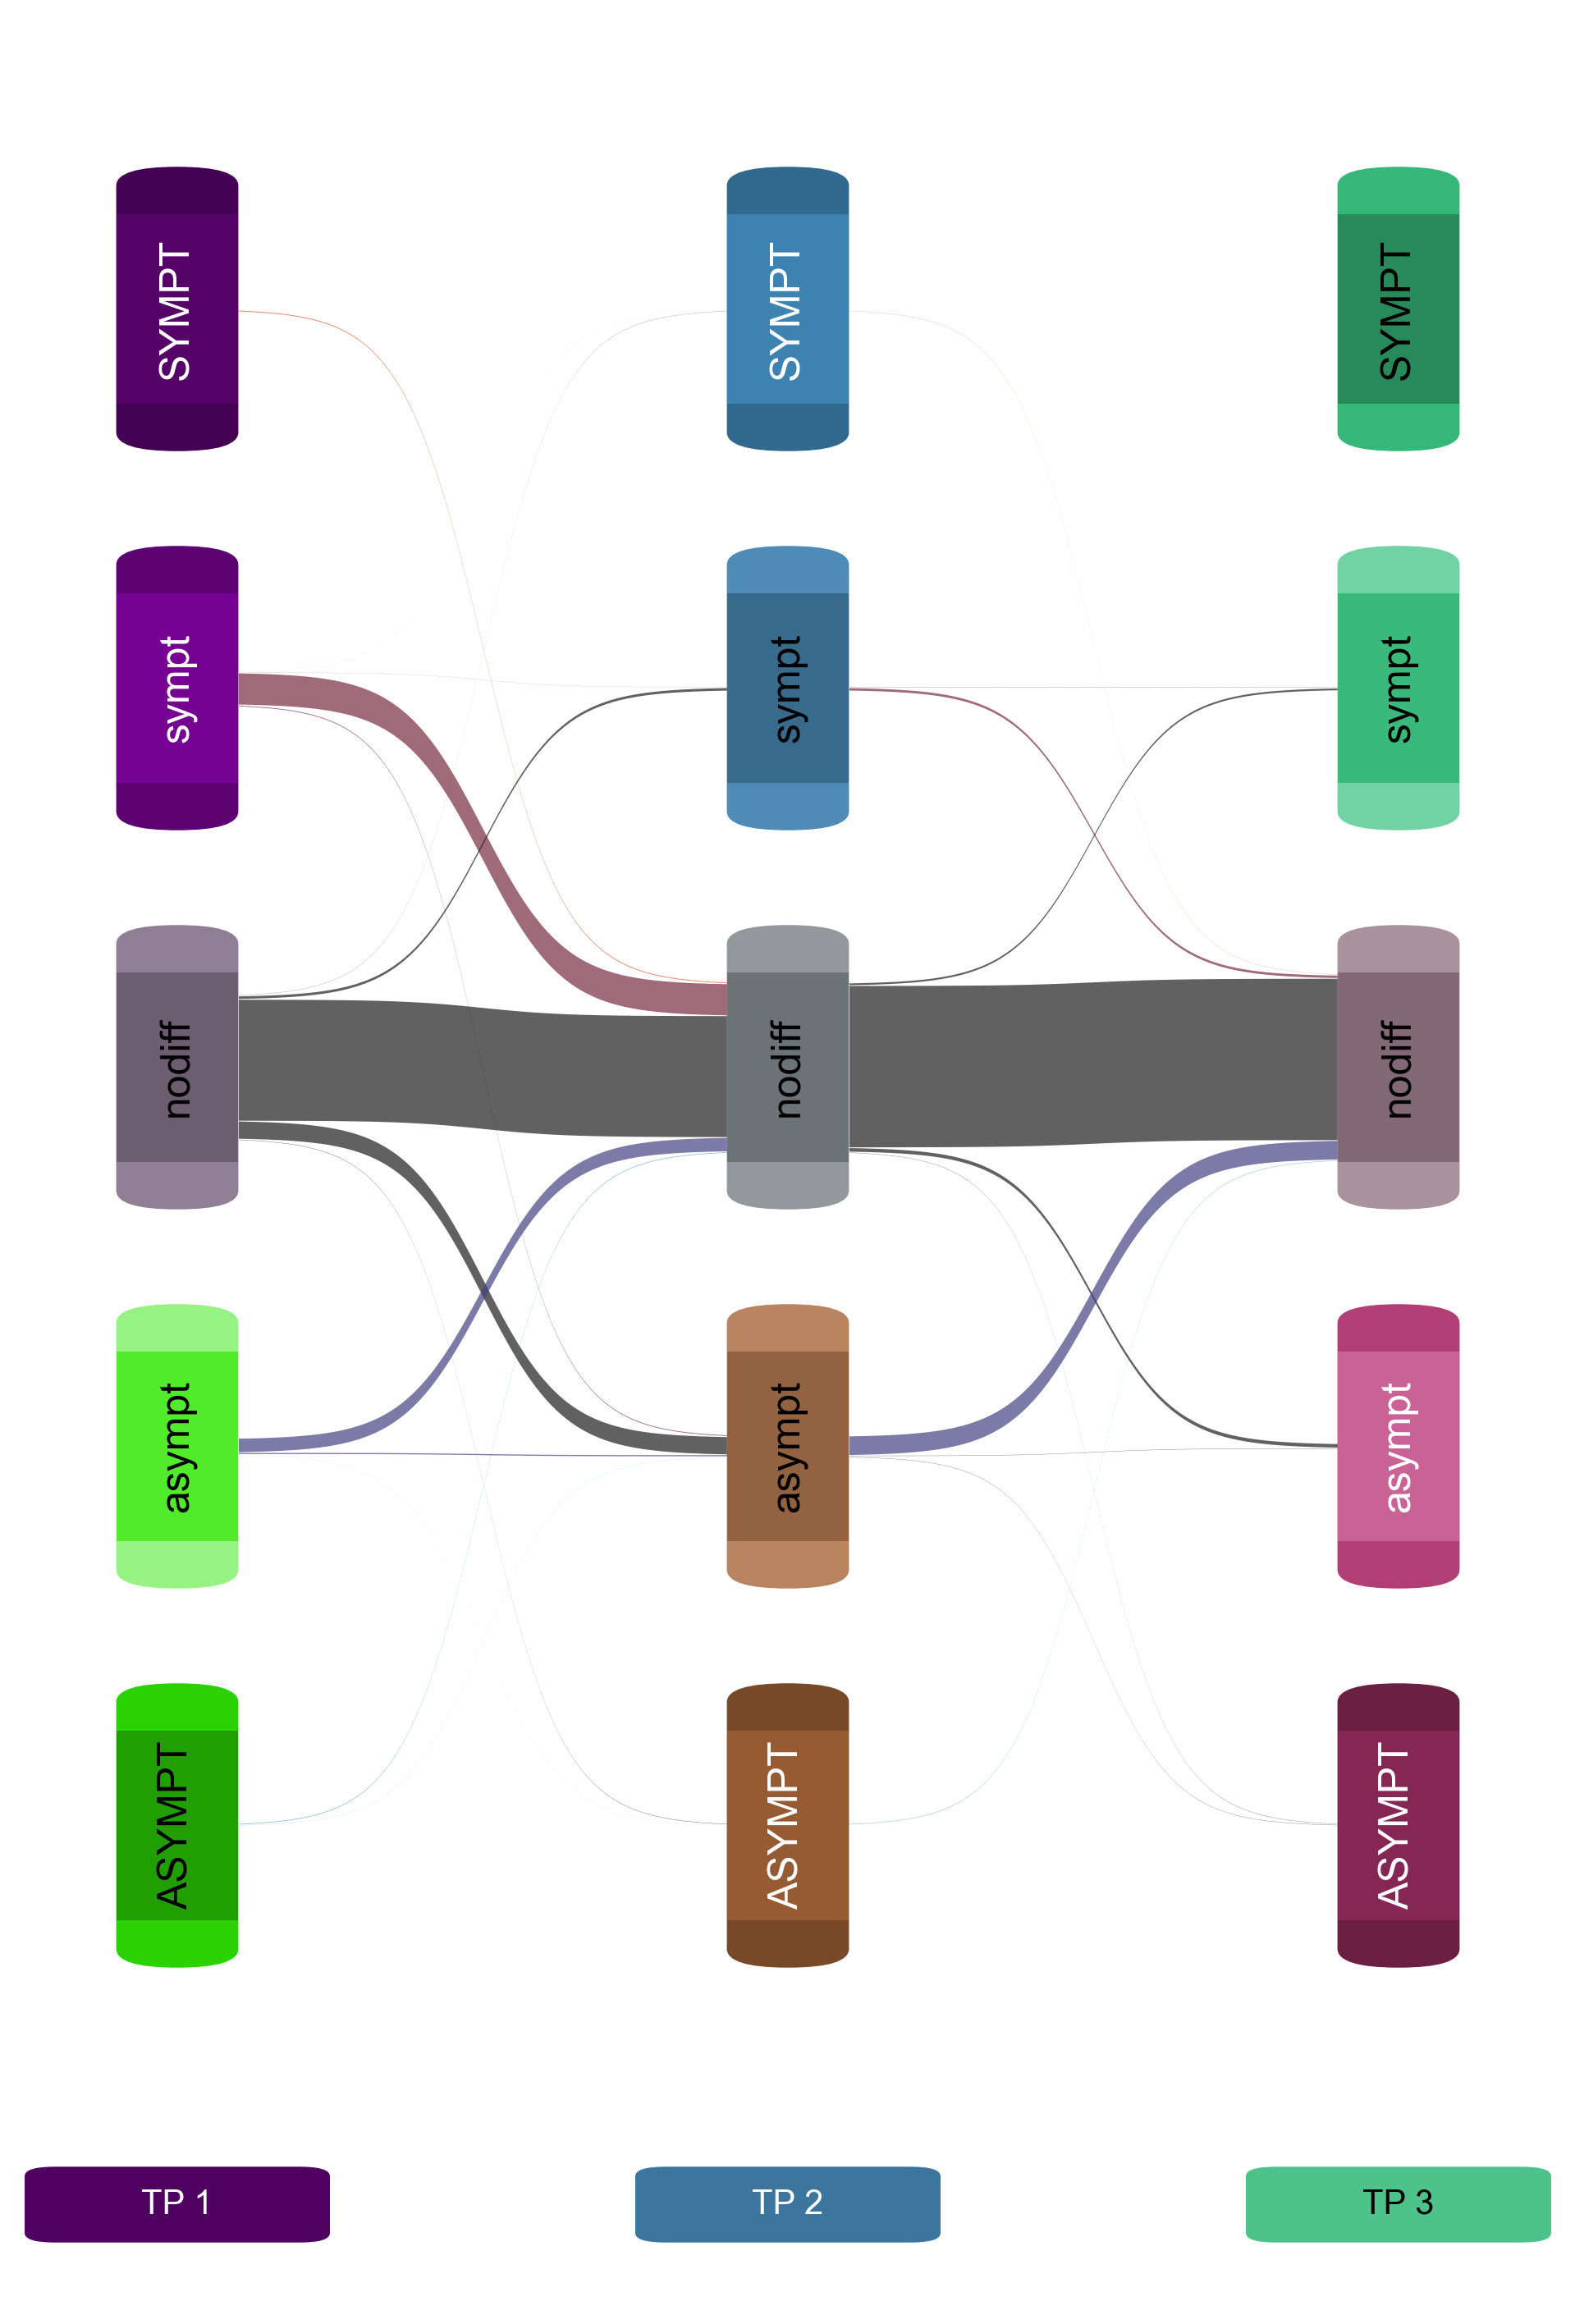

In [20]:
# Plot all flows with diverging color mode and custom color map
fa.plot_flows(figsize=(8,12), verbose=False, seriesColors=sc, colorMode="diverging", outfile="plots/ddiff_flows_all_diverging")

In [21]:
# Find edges (gene flow patterns) associated with asymptomatic states
relEdgesAsympt = fa.flow_finder(["<", "<="], maxLevels=["asympt", None, None], verbose=True)
print(relEdgesAsympt)

15 (('tp01', 'asympt'), ('tp02', 'SYMPT'))
16 (('tp01', 'asympt'), ('tp02', 'sympt'))
17 (('tp01', 'asympt'), ('tp02', 'nodiff'))
20 (('tp01', 'ASYMPT'), ('tp02', 'SYMPT'))
21 (('tp01', 'ASYMPT'), ('tp02', 'sympt'))
22 (('tp01', 'ASYMPT'), ('tp02', 'nodiff'))
23 (('tp01', 'ASYMPT'), ('tp02', 'asympt'))
25 (('tp02', 'SYMPT'), ('tp03', 'SYMPT'))
30 (('tp02', 'sympt'), ('tp03', 'SYMPT'))
31 (('tp02', 'sympt'), ('tp03', 'sympt'))
35 (('tp02', 'nodiff'), ('tp03', 'SYMPT'))
36 (('tp02', 'nodiff'), ('tp03', 'sympt'))
37 (('tp02', 'nodiff'), ('tp03', 'nodiff'))
40 (('tp02', 'asympt'), ('tp03', 'SYMPT'))
41 (('tp02', 'asympt'), ('tp03', 'sympt'))
42 (('tp02', 'asympt'), ('tp03', 'nodiff'))
43 (('tp02', 'asympt'), ('tp03', 'asympt'))
45 (('tp02', 'ASYMPT'), ('tp03', 'SYMPT'))
46 (('tp02', 'ASYMPT'), ('tp03', 'sympt'))
47 (('tp02', 'ASYMPT'), ('tp03', 'nodiff'))
48 (('tp02', 'ASYMPT'), ('tp03', 'asympt'))
49 (('tp02', 'ASYMPT'), ('tp03', 'ASYMPT'))
{15, 16, 17, 20, 21, 22, 23, 25, 30, 31, 35, 36,

In [22]:
# Find edges (gene flow patterns) associated with symptomatic states
relEdgesSympt = fa.flow_finder([">", ">="], minLevels=["sympt", None, None], verbose=True)
print(relEdgesSympt)

1 (('tp01', 'SYMPT'), ('tp02', 'sympt'))
2 (('tp01', 'SYMPT'), ('tp02', 'nodiff'))
3 (('tp01', 'SYMPT'), ('tp02', 'asympt'))
4 (('tp01', 'SYMPT'), ('tp02', 'ASYMPT'))
7 (('tp01', 'sympt'), ('tp02', 'nodiff'))
8 (('tp01', 'sympt'), ('tp02', 'asympt'))
9 (('tp01', 'sympt'), ('tp02', 'ASYMPT'))
25 (('tp02', 'SYMPT'), ('tp03', 'SYMPT'))
26 (('tp02', 'SYMPT'), ('tp03', 'sympt'))
27 (('tp02', 'SYMPT'), ('tp03', 'nodiff'))
28 (('tp02', 'SYMPT'), ('tp03', 'asympt'))
29 (('tp02', 'SYMPT'), ('tp03', 'ASYMPT'))
31 (('tp02', 'sympt'), ('tp03', 'sympt'))
32 (('tp02', 'sympt'), ('tp03', 'nodiff'))
33 (('tp02', 'sympt'), ('tp03', 'asympt'))
34 (('tp02', 'sympt'), ('tp03', 'ASYMPT'))
37 (('tp02', 'nodiff'), ('tp03', 'nodiff'))
38 (('tp02', 'nodiff'), ('tp03', 'asympt'))
39 (('tp02', 'nodiff'), ('tp03', 'ASYMPT'))
43 (('tp02', 'asympt'), ('tp03', 'asympt'))
44 (('tp02', 'asympt'), ('tp03', 'ASYMPT'))
49 (('tp02', 'ASYMPT'), ('tp03', 'ASYMPT'))
{1, 2, 3, 4, 7, 8, 9, 25, 26, 27, 28, 29, 31, 32, 33, 34, 3

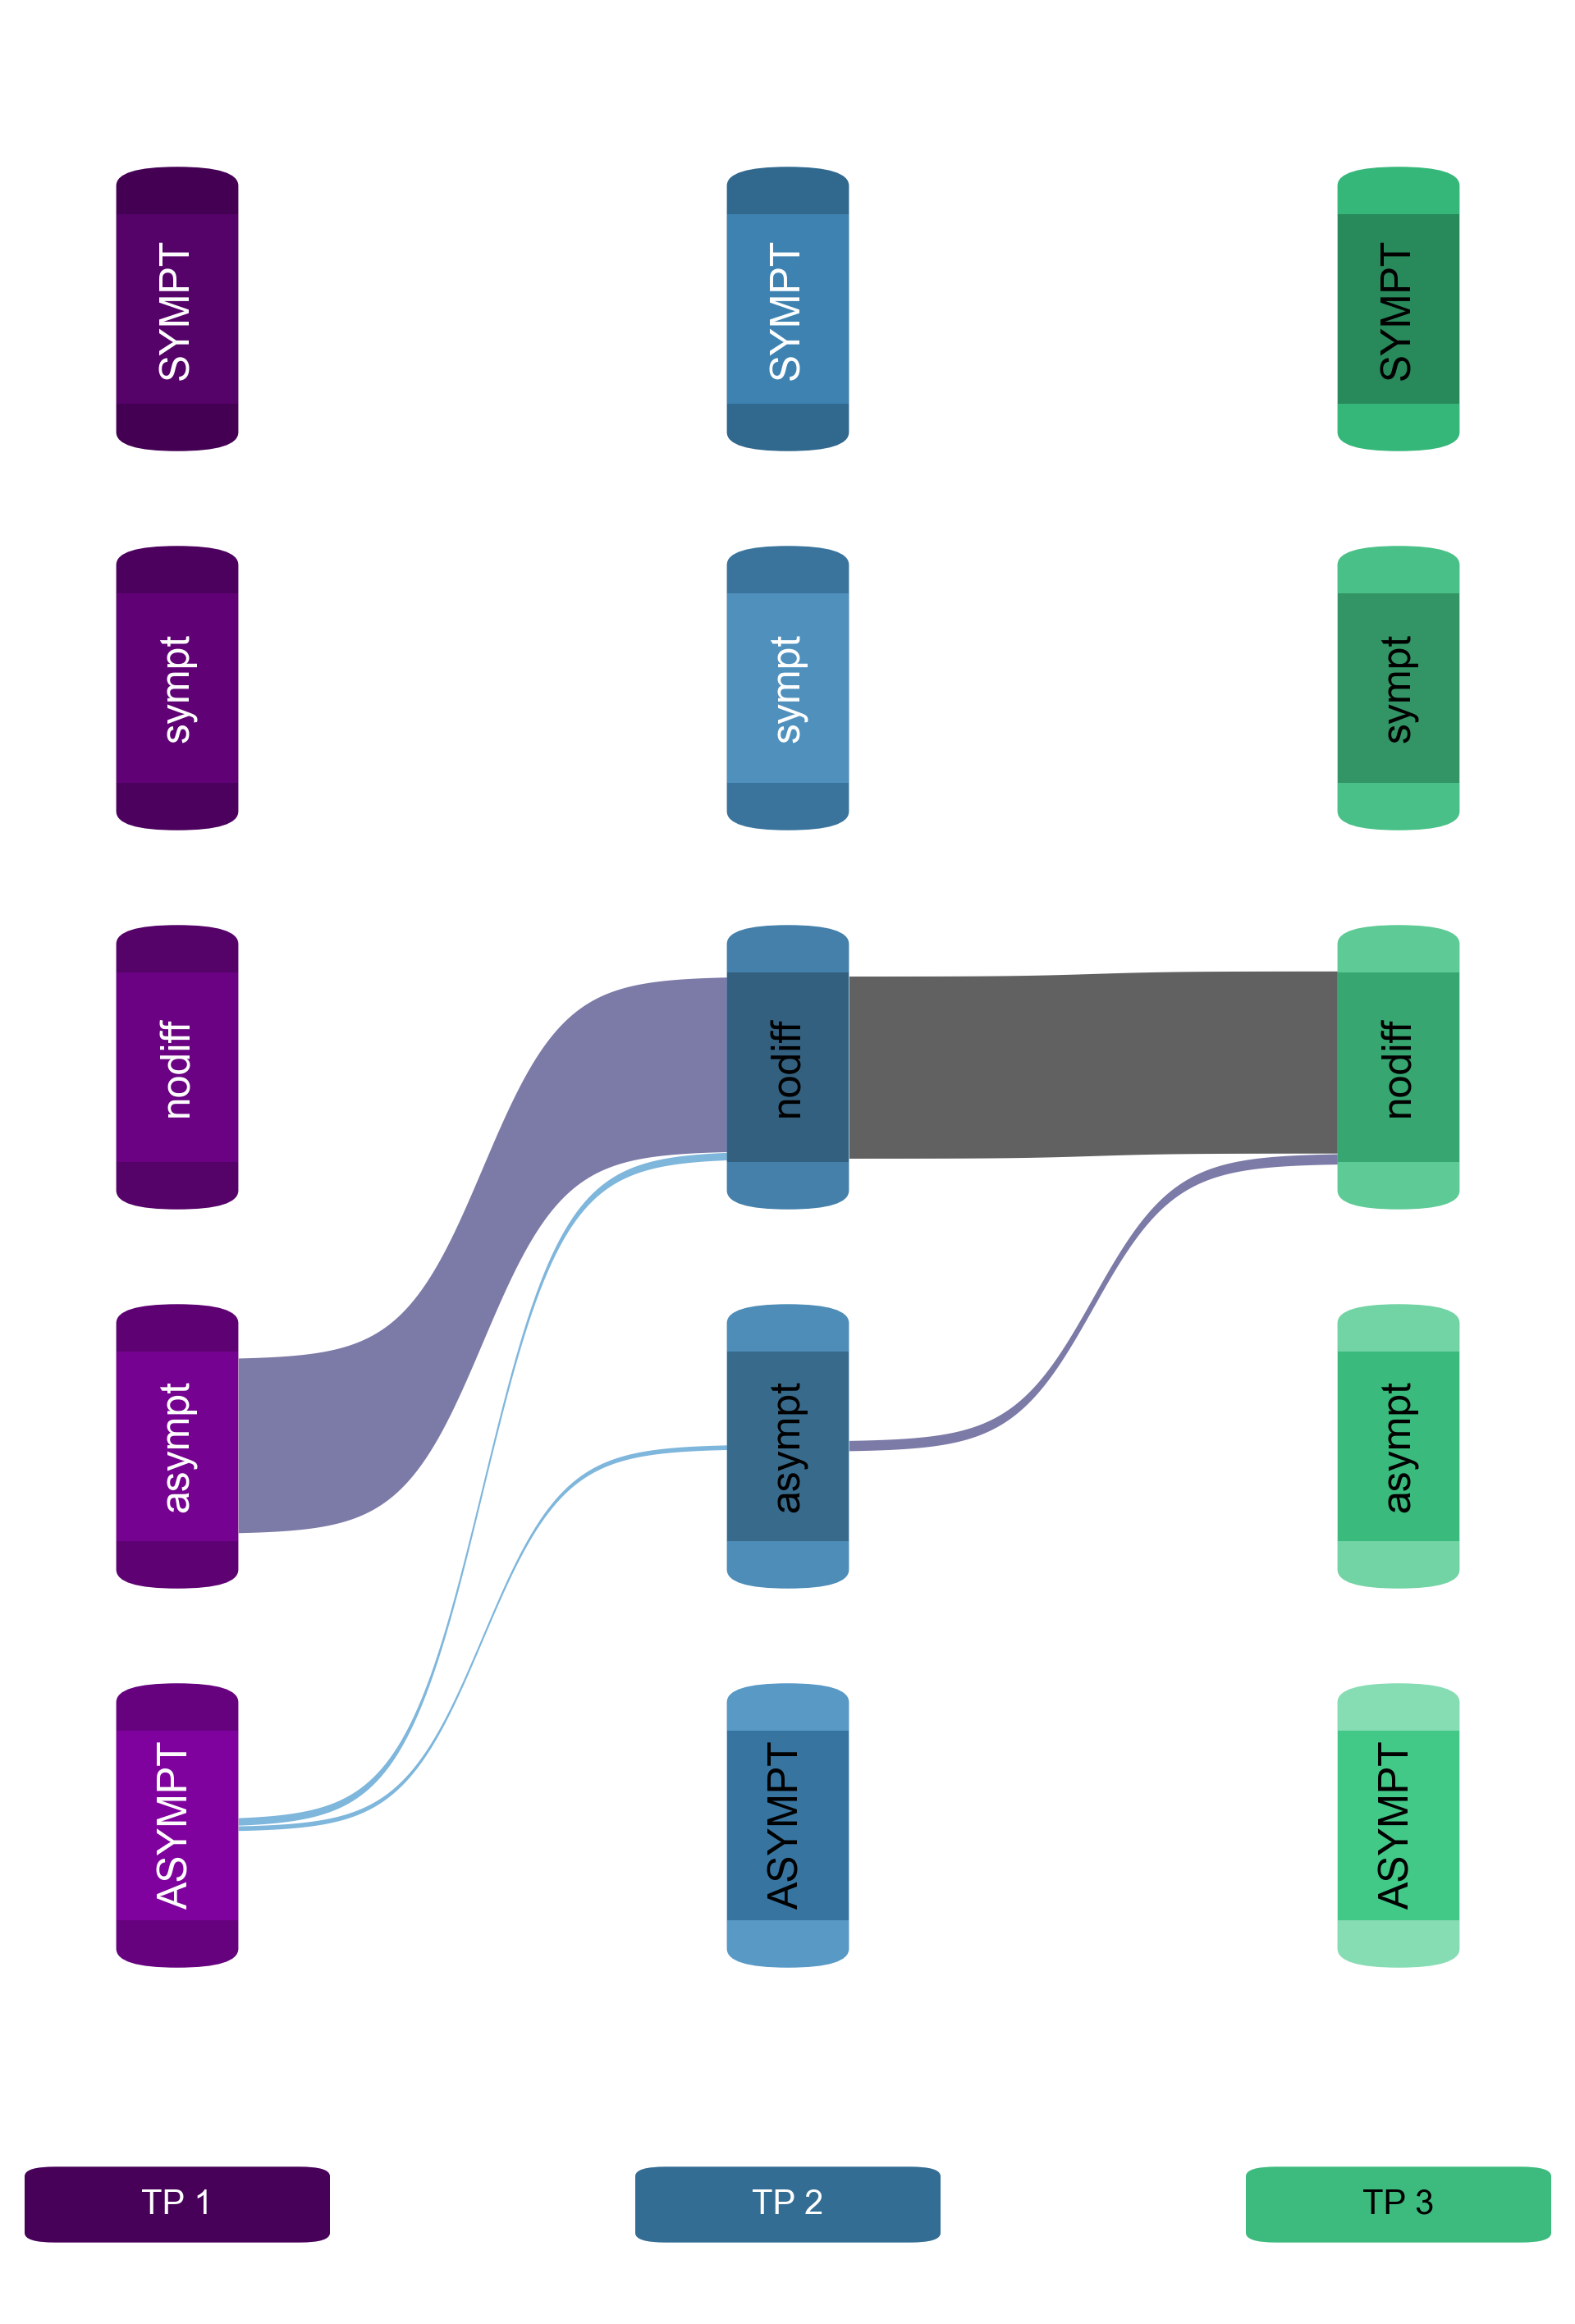

In [23]:
# Plot flows for asymptomatic pattern edges
fa.plot_flows(use_edges=relEdgesAsympt, seriesColors=sc, figsize=(8,12), outfile="plots/ddiff_flows_asympt")

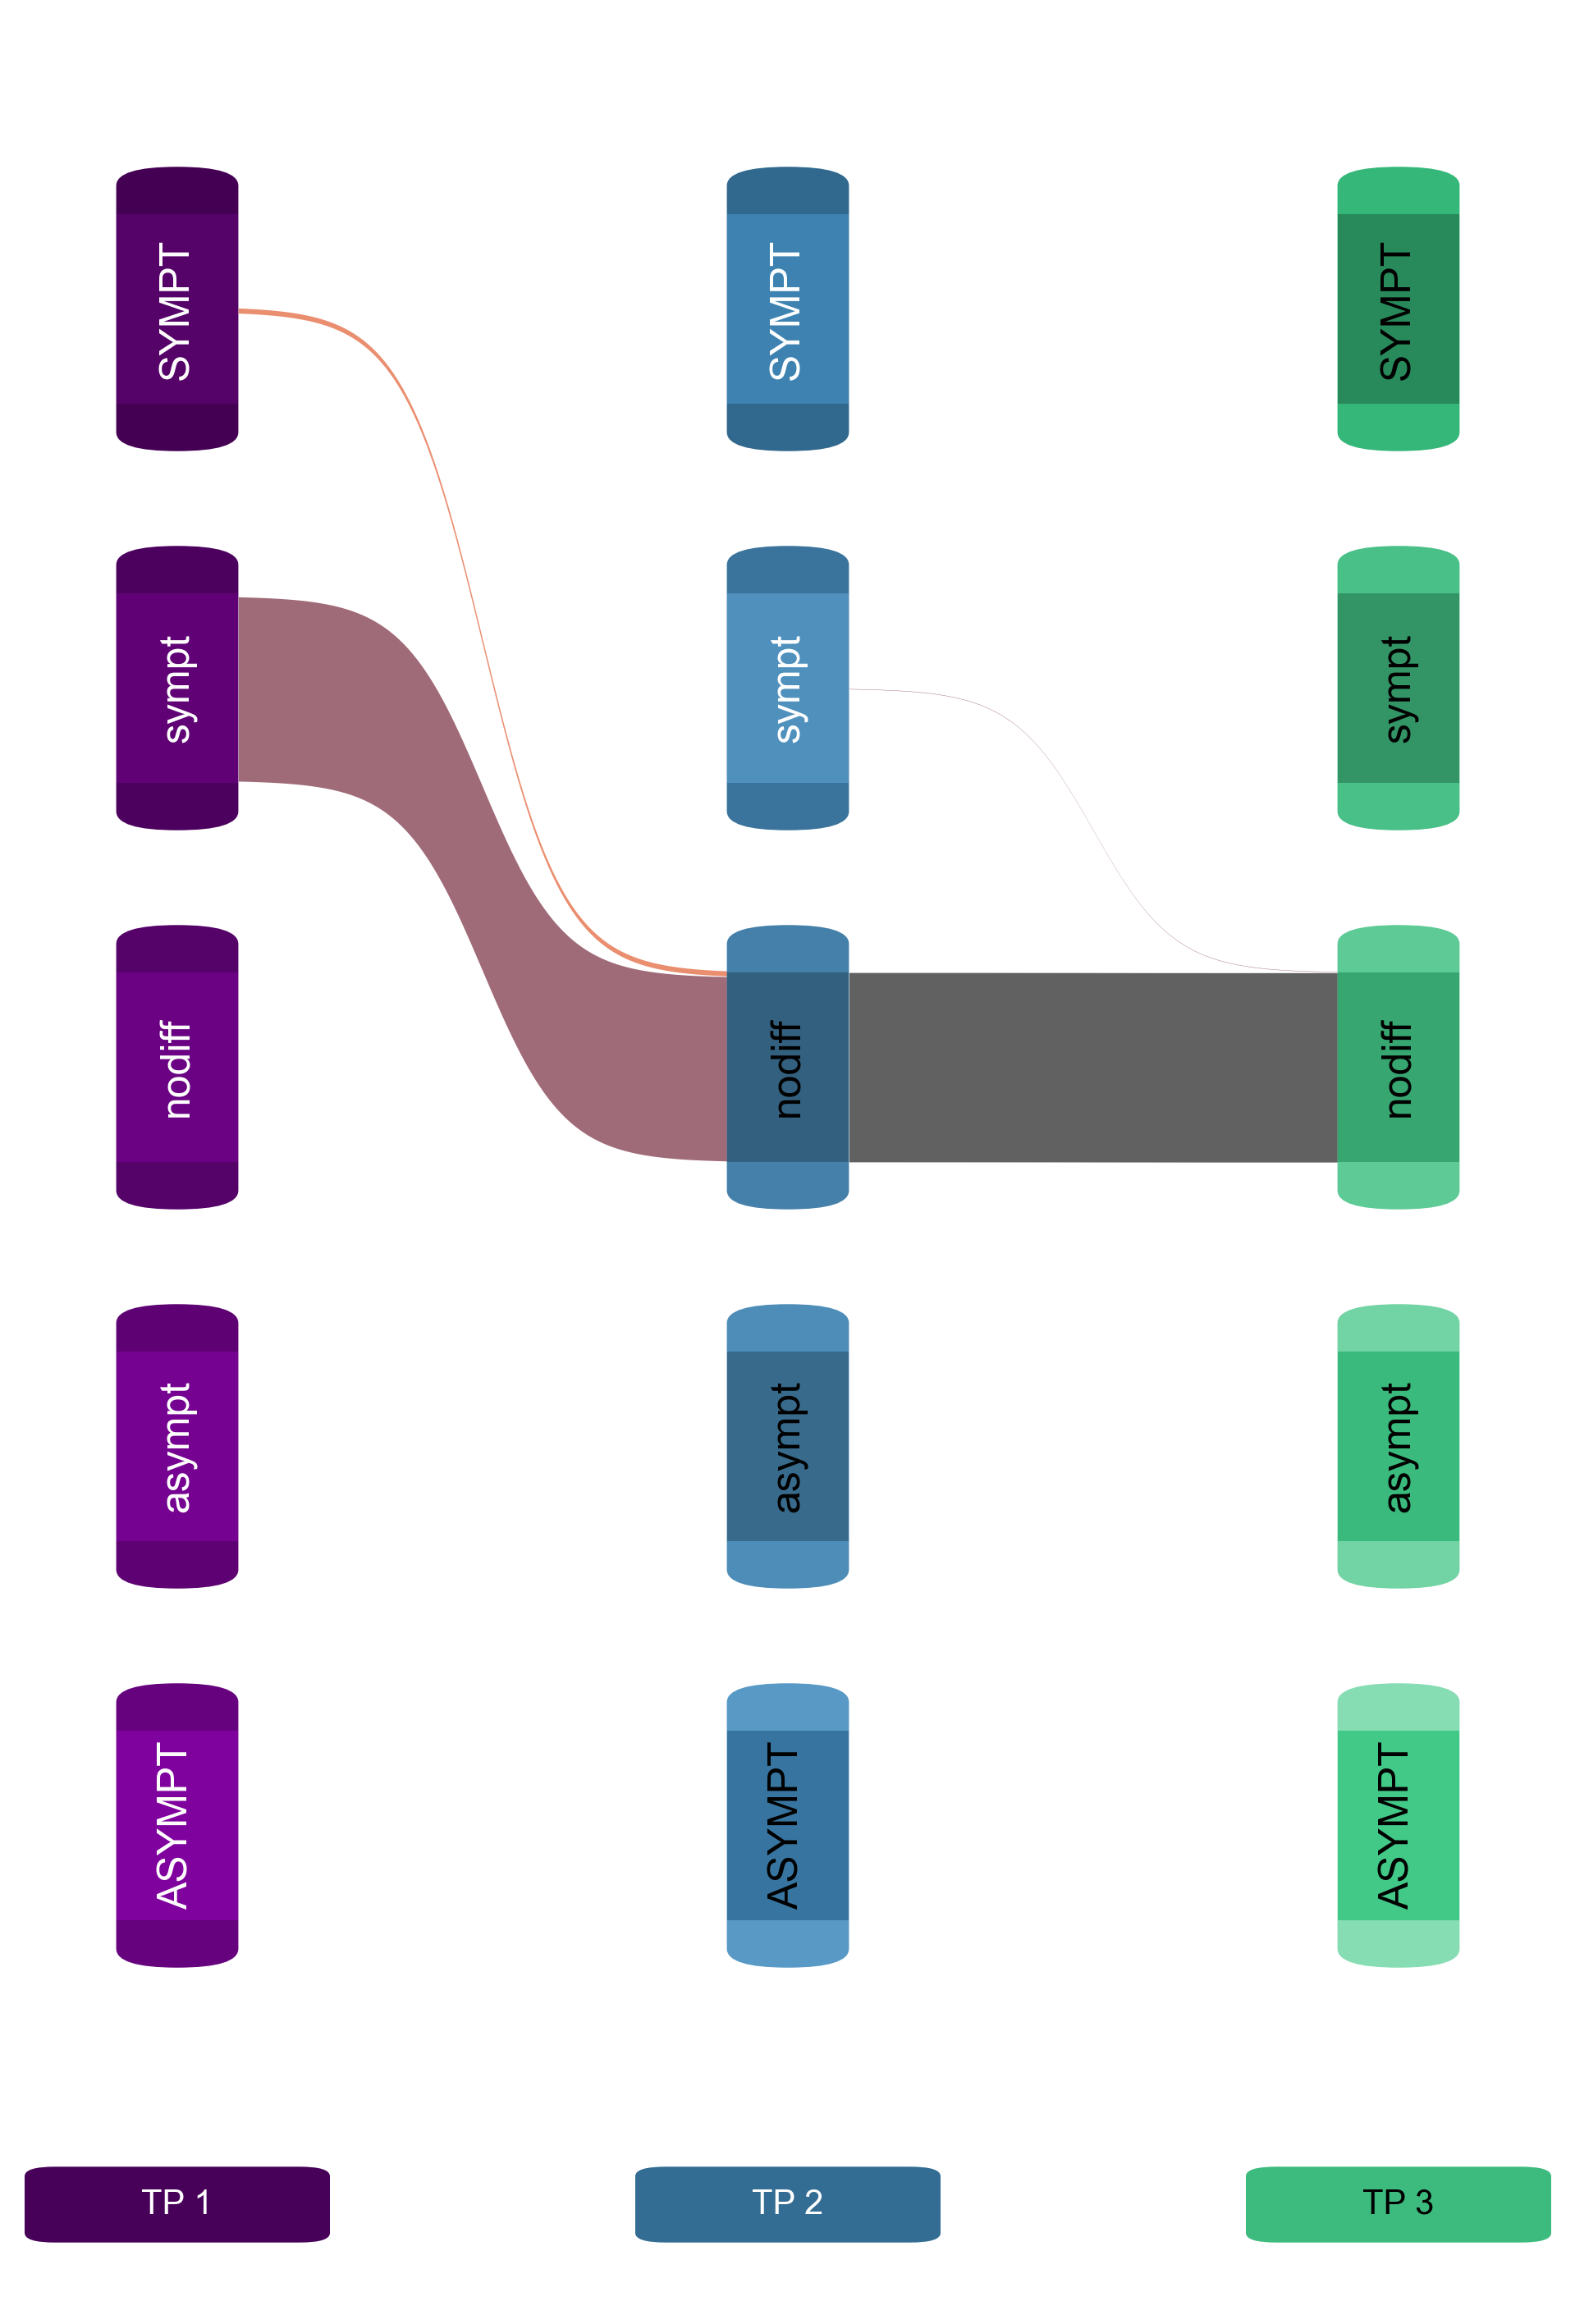

In [24]:
# Plot flows for symptomatic pattern edges
fa.plot_flows(use_edges=relEdgesSympt, seriesColors=sc, figsize=(8,12), outfile="plots/ddiff_flows_sympt")

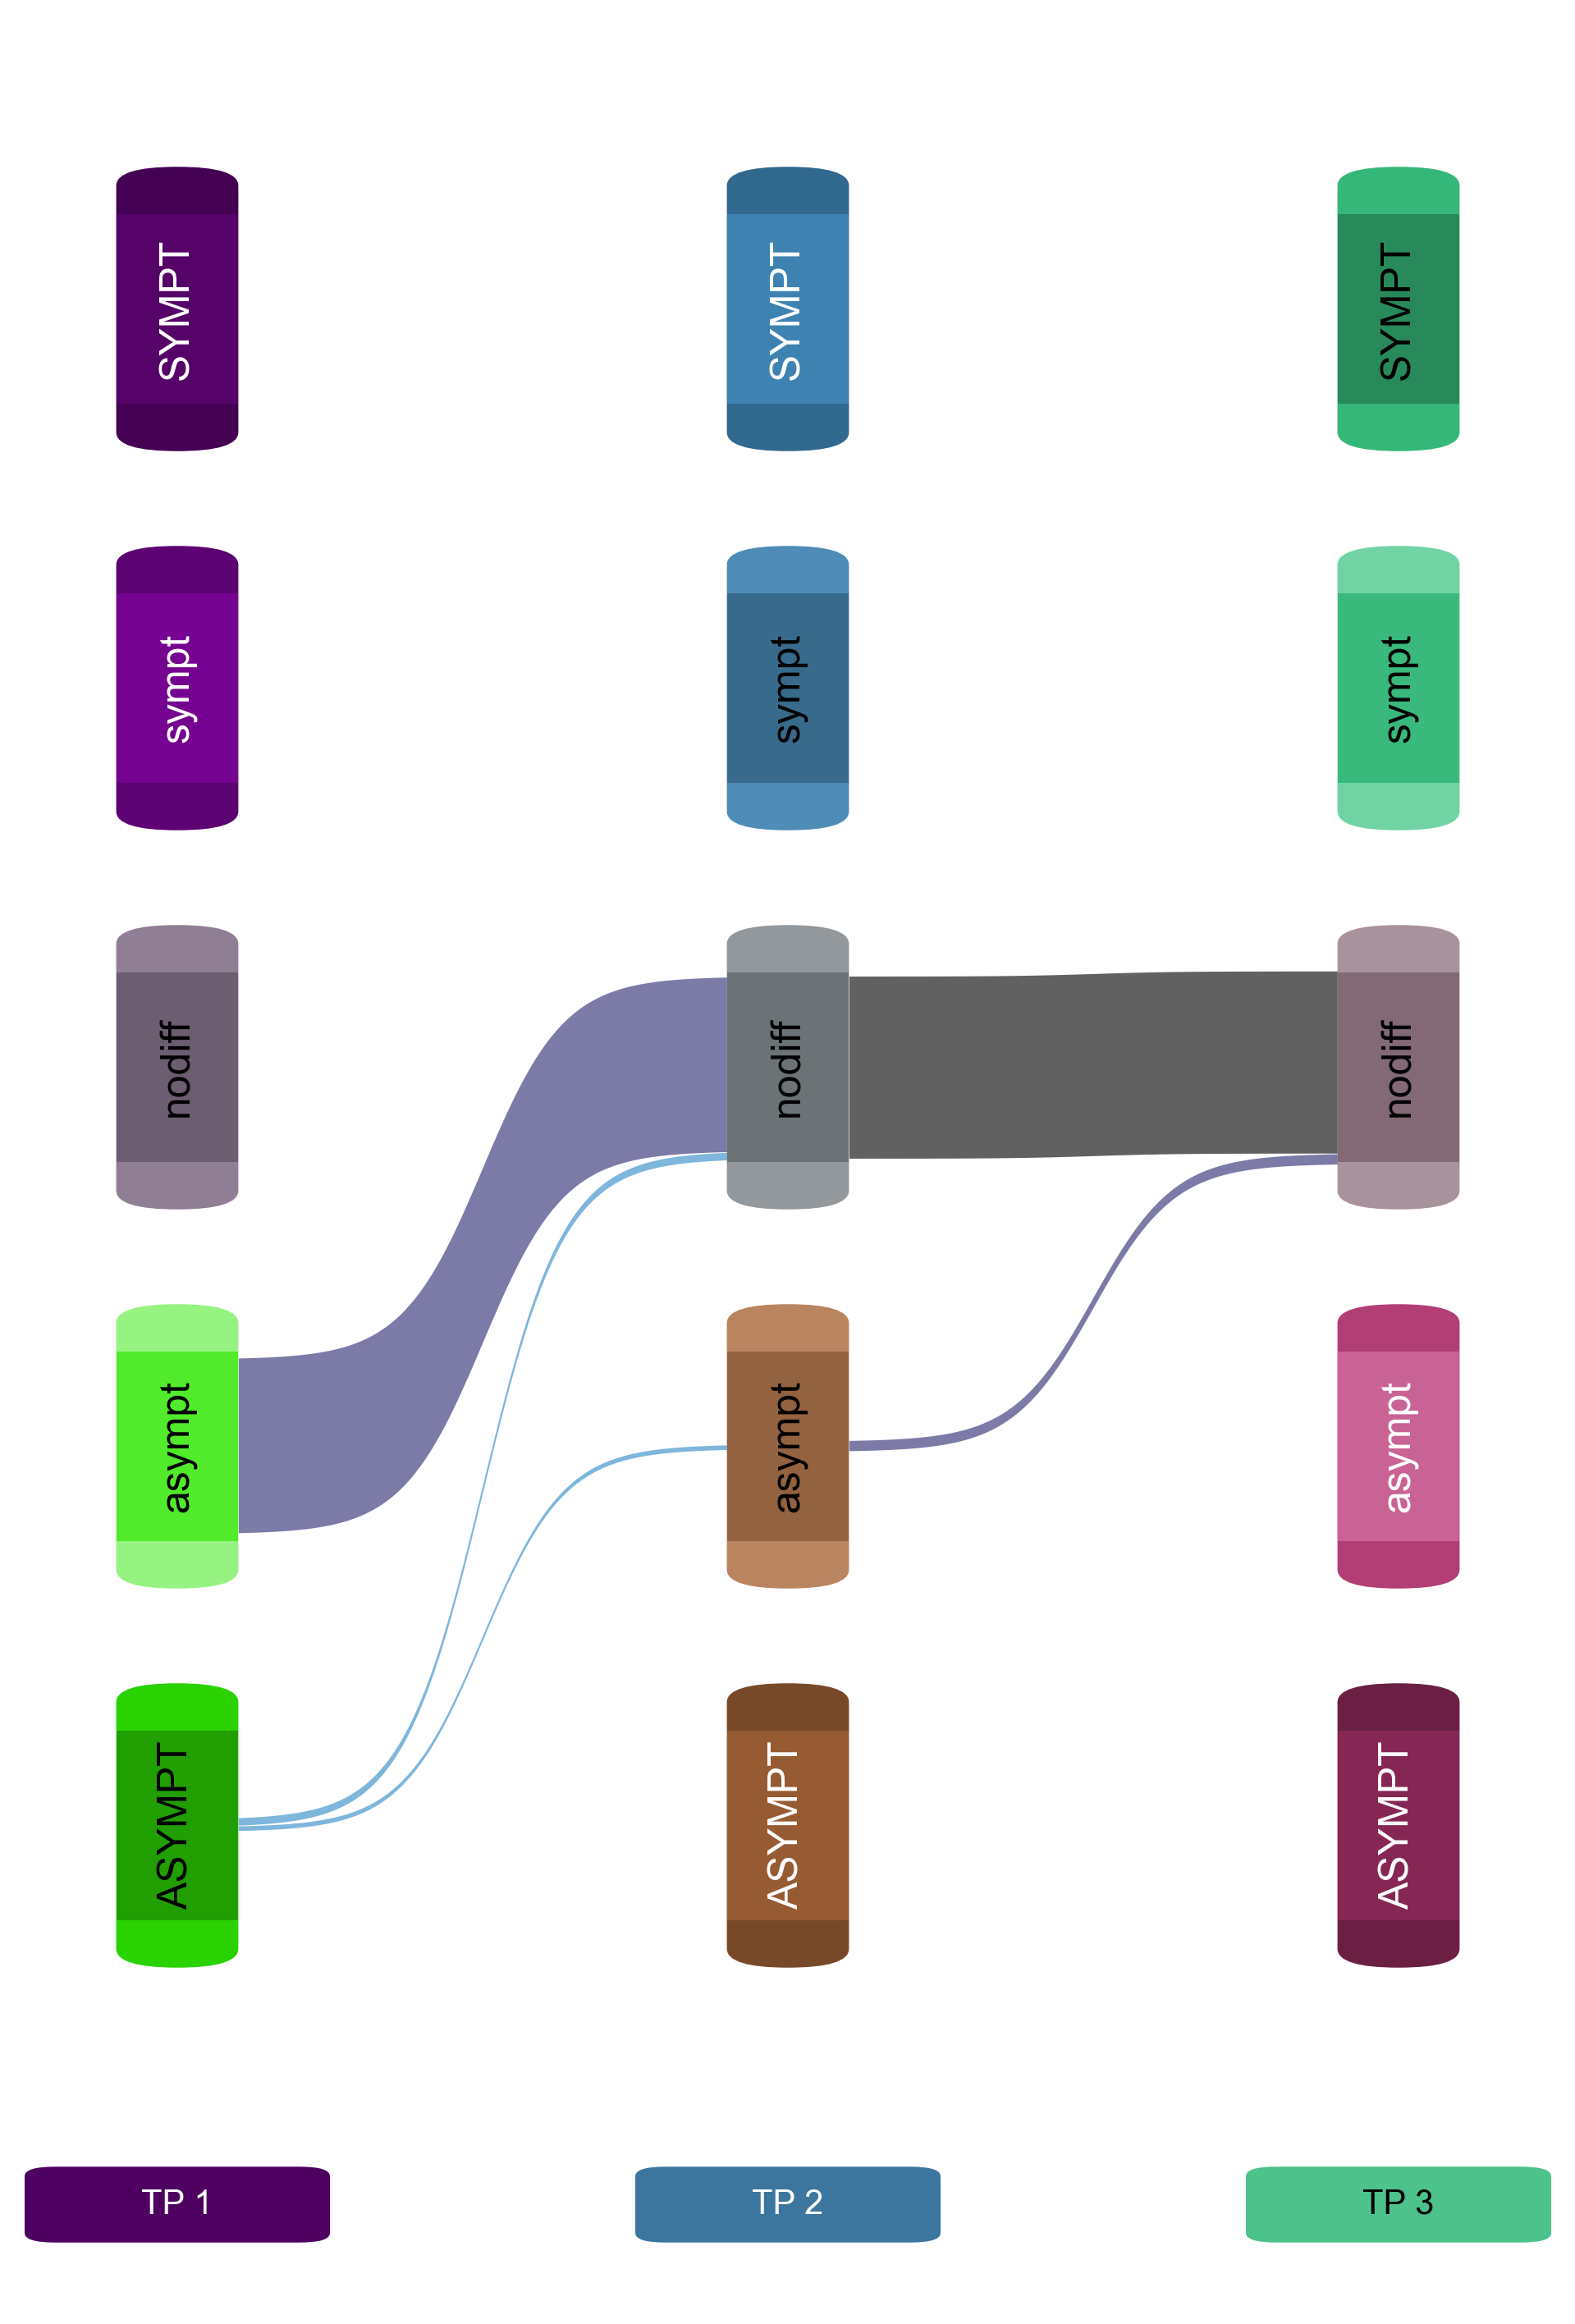

In [25]:
# Plot flows for asymptomatic pattern edges with diverging color mode
fa.plot_flows(use_edges=relEdgesAsympt, seriesColors=sc, figsize=(8,12), outfile="plots/ddiff_flows_asympt_diverging", colorMode="diverging")

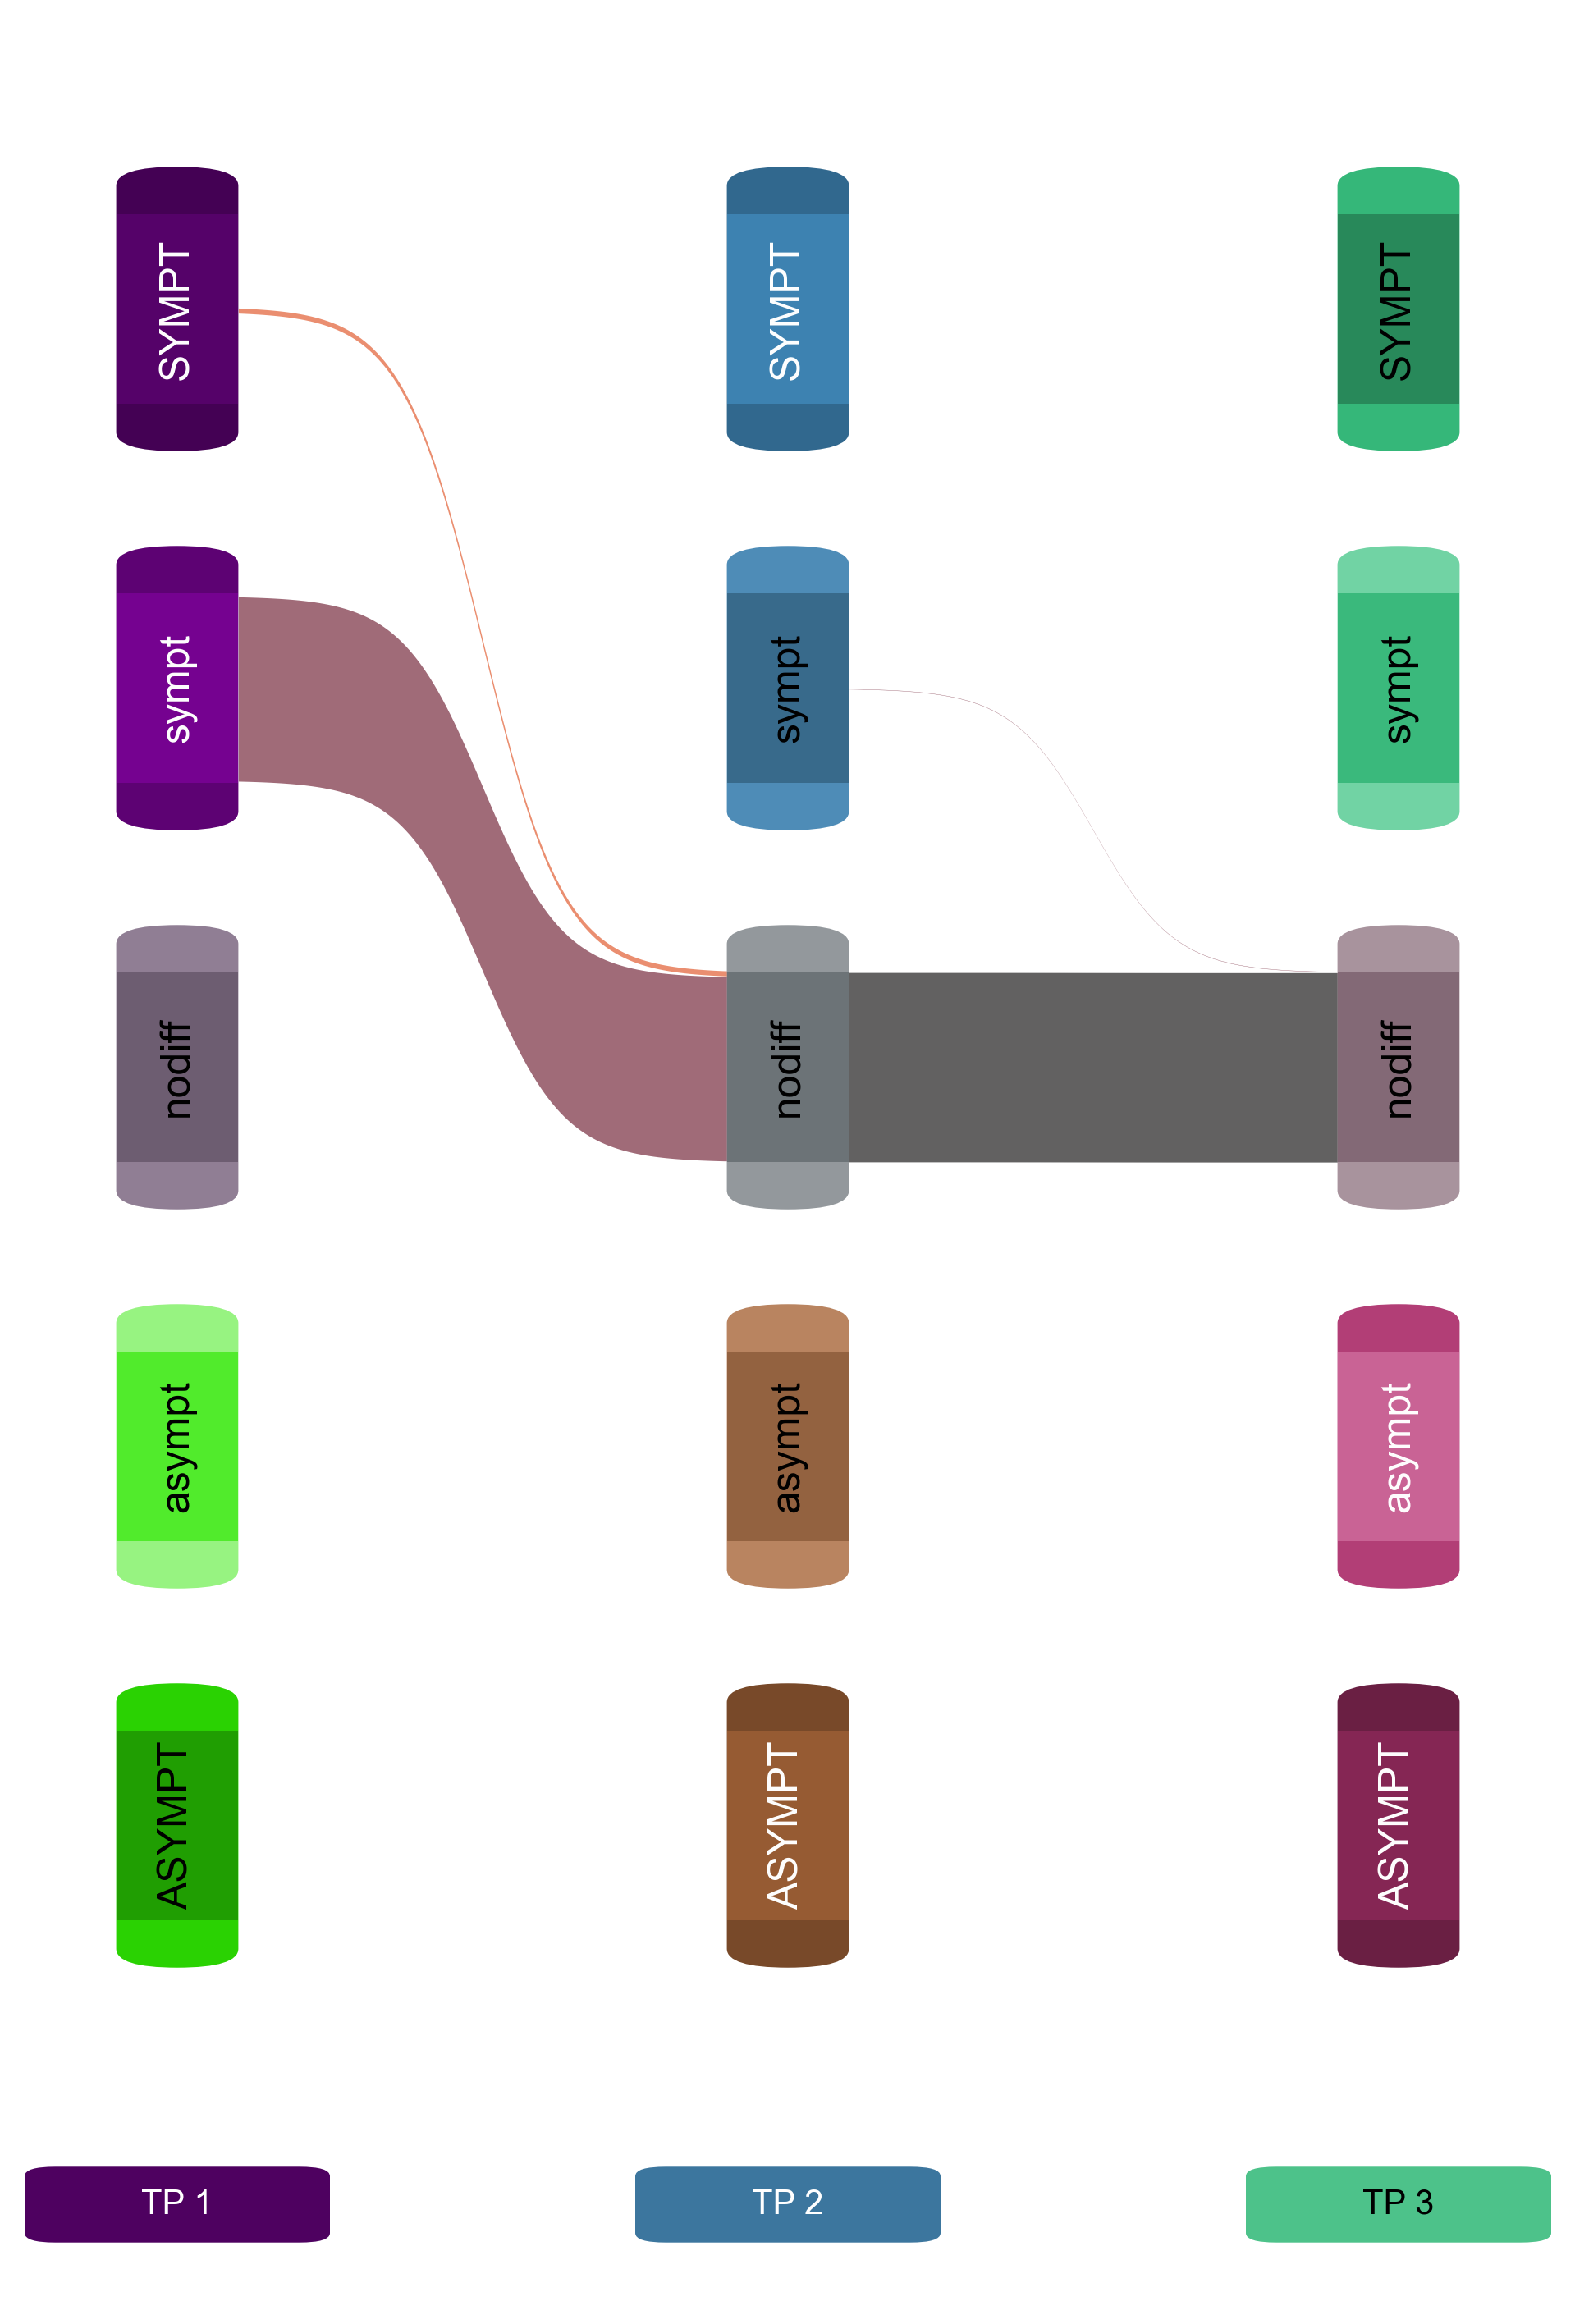

In [26]:
# Plot flows for symptomatic pattern edges with diverging color mode
fa.plot_flows(use_edges=relEdgesSympt, seriesColors=sc, figsize=(8,12), outfile="plots/ddiff_flows_sympt_diverging", colorMode="diverging")

In [27]:
# ...existing code...

In [28]:
# Pathway analysis for asymptomatic and symptomatic patterns using ISG gene sets
pwScoresAsymptGrp = fa.analyse_pathways(additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdgesAsympt)
pwScoresSymptGrp = fa.analyse_pathways(additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdgesSympt)

Loading pathways from ReactomePathways.gmt
Identified 2612 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(2605)]
Loading pathways from ReactomePathways.gmt
Identified 2612 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(2605)]


In [29]:
# ...existing code...

pwid                                             pwname  \
2442   R-HSA-202430   Translocation of ZAP-70 to Immunological synapse   
1652   R-HSA-202427         Phosphorylation of CD3 and TCR zeta chains   
1569   R-HSA-389948                                     PD-1 signaling   
2612      ISG_SHORT                                          ISG_SHORT   
2613       ISG_LONG                                           ISG_LONG   
993    R-HSA-202433           Generation of second messenger molecules   
825   R-HSA-9634638  Estrogen-dependent nuclear events downstream o...   
392    R-HSA-388841                   Costimulation by the CD28 family   
1525   R-HSA-198725  Nuclear Events (kinase and transcription facto...   
908     R-HSA-72689           Formation of a pool of free 40S subunits   
1166   R-HSA-877300                         Interferon gamma signaling   
753    R-HSA-202424                           Downstream TCR signaling   
1301  R-HSA-2132295                  MHC class II antigen presentation   
1439  R-HSA-9031628                       NGF-stimulated transcription   
1228   R-HSA-156827  L13a-mediated translational silencing of Cerul...   
2565    R-HSA-72200                    mRNA Editing: C to U Conversion   
918     R-HSA-75094                         Formation of the Editosome   
976     R-HSA-72706  GTP hydrolysis and joining of the 60S ribosoma...   
2512   R-HSA-192823                             Viral mRNA Translation   
99     R-HSA-450341  Activation of the AP-1 family of transcription...   

        pwFlow  pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  \
2442  2.430285       26  23.437923  229.000003                     5   
1652  2.430285       29  23.437923  229.000003                     5   
1569  2.430285       30  23.437923  229.000003                     5   
2612  1.216680       17  23.437923  229.000003                     3   
2613  1.928630       55  23.437923  229.000003                     7   
993   2.430285       41  23.437923  229.000003                     5   
825   1.274579       24  23.437923  229.000003                     4   
392   2.430285       78  23.437923  229.000003                     6   
1525  1.847614       62  23.437923  229.000003                     6   
908   2.657097      106  23.437923  229.000003                     7   
1166  2.731783       99  23.437923  229.000003                     9   
753   2.430285      104  23.437923  229.000003                     7   
1301  2.935230      127  23.437923  229.000003                     8   
1439  1.847614       40  23.437923  229.000003                     6   
1228  2.657097      116  23.437923  229.000003                     7   
2565  0.625787        8  23.437923  229.000003                     1   
918   0.625787        8  23.437923  229.000003                     1   
976   2.657097      117  23.437923  229.000003                     7   
2512  2.290831      102  23.437923  229.000003                     6   
99    0.752000       10  23.437923  229.000003                     1   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
2442     0.093472        0.103690       0.009692            7.348884   
1652     0.083803        0.103690       0.008690            6.546107   
1569     0.081009        0.103690       0.008400            6.314194   
2612     0.071569        0.051911       0.003715            5.530469   
2613     0.035066        0.082287       0.002885            4.591823   
993      0.059275        0.103690       0.006146            4.509796   
825      0.053107        0.054381       0.002888            3.997742   
392      0.031157        0.103690       0.003231            4.012701   
1525     0.029800        0.078830       0.002349            3.811595   
908      0.025067        0.113367       0.002842            3.780657   
1166     0.027594        0.116554       0.003216            3.484664   
753      0.023368        0.103690       0.002423            3.476963   
1301     0.

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


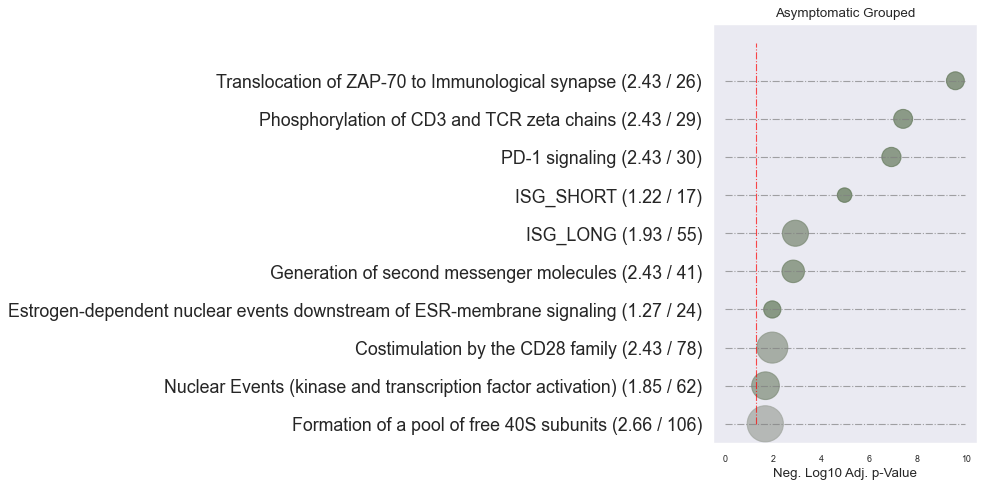

In [30]:
# Select and plot top pathways for asymptomatic group
selPWsAsymptGrp = pwScoresAsymptGrp[(pwScoresAsymptGrp["pw_coverage_adj_pval"] < 0.2)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsAsymptGrp)
fa.plotORAresult(selPWsAsymptGrp, "Asymptomatic Grouped", numResults=10, figsize=(6,6), outfile="plots/ddiff_asympt_ra")

pwid                                             pwname  \
2398  R-HSA-1679131        Trafficking and processing of endosomal TLR   
2417  R-HSA-2173793  Transcriptional activity of SMAD2/SMAD3:SMAD4 ...   
2184  R-HSA-9006936                   Signaling by TGFB family members   
169   R-HSA-2022090  Assembly of collagen fibrils and other multime...   
1189  R-HSA-6785807         Interleukin-4 and Interleukin-13 signaling   
751   R-HSA-2173795  Downregulation of SMAD2/3:SMAD4 transcriptiona...   
702   R-HSA-2022923                      Dermatan sulfate biosynthesis   
1458  R-HSA-9024446                 NR1H2 and NR1H3-mediated signaling   
2411  R-HSA-8986944                Transcriptional Regulation by MECP2   
178   R-HSA-9678110                       Attachment and Entry_9678110   
1267  R-HSA-9005891         Loss of function of MECP2 in Rett syndrome   
740   R-HSA-9675151                 Disorders of Developmental Biology   
1632  R-HSA-9005895                  Pervasive developmental disorders   
741   R-HSA-9697154            Disorders of Nervous System Development   
368   R-HSA-1442490                               Collagen degradation   
1191  R-HSA-1059683                            Interleukin-6 signaling   
805   R-HSA-1236977                         Endosomal/Vacuolar pathway   

        pwFlow  pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  \
2398  1.269038       13   52.88324  229.000003                     2   
2417  2.036551       51   52.88324  229.000003                     5   
2184  2.458163      122   52.88324  229.000003                     6   
169   1.724644       61   52.88324  229.000003                     3   
1189  2.037556      112   52.88324  229.000003                    12   
751   2.036551       31   52.88324  229.000003                     4   
702   0.714000       11   52.88324  229.000003                     1   
1458  1.416515       54   52.88324  229.000003                     3   
2411  1.628167       63   52.88324  229.000003                     6   
178   0.654222       11   52.88324  229.000003                     1   
1267  0.738163       13   52.88324  229.000003                     2   
740   0.738163       13   52.88324  229.000003                     2   
1632  0.738163       13   52.88324  229.000003                     2   
741   0.738163       13   52.88324  229.000003                     2   
368   1.504172       64   52.88324  229.000003                     3   
1191  0.599417       11   52.88324  229.000003                     1   
805   0.654222       12   52.88324  229.000003                     1   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
2398     0.097618        0.023997       0.002343            6.060125   
2417     0.039932        0.038510       0.001538            5.858686   
2184     0.020149        0.046483       0.000937            4.464113   
169      0.028273        0.032612       0.000922            3.917851   
1189     0.018192        0.038529       0.000701            3.924410   
751      0.065695        0.038510       0.002530            3.837654   
702      0.064909        0.013501       0.000876            3.782926   
1458     0.026232        0.026786       0.000703            3.578092   
2411     0.025844        0.030788       0.000796            3.513531   
178      0.059475        0.012371       0.000736            3.404588   
1267     0.056782        0.013958       0.000793            3.217107   
740      0.056782        0.013958       0.000793            3.217107   
1632     0.056782        0.013958       0.000793            3.217107   
741      0.056782        0.013958       0.000793            3.217107   
368      0.023503        0.028443       0.000668            3.123811   
1191     0.054492        0.011335       0.000618            3.057723   
805      0.054518        0.012371       0.000674            3.059538   

      pw_coverage_pval  pw_coverage_adj_pval  
2398      6.800772e-10              0.000

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


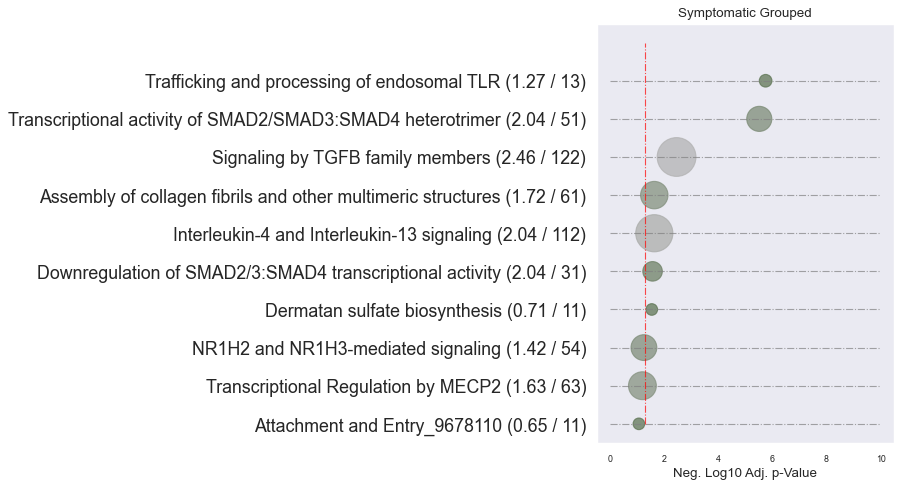

In [31]:
# Select and plot top pathways for symptomatic group
selPWsSymptGrp = pwScoresSymptGrp[(pwScoresSymptGrp["pw_coverage_adj_pval"] < 0.2)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsSymptGrp)
fa.plotORAresult(selPWsSymptGrp, "Symptomatic Grouped", numResults=10, figsize=(6, 6), outfile="plots/ddiff_sympt_ra")

In [32]:
# Pathway analysis using GO biological process gene sets
pwScoresAsymptGrpGO = fa.analyse_pathways(genesets_file="go_human.bp.gmt", additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdgesAsympt)
pwScoresSymptGrpGO = fa.analyse_pathways(genesets_file="go_human.bp.gmt", additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdgesSympt)

Loading pathways from go_human.bp.gmt
Identified 12535 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(1226)]
Loading pathways from go_human.bp.gmt
Identified 12535 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, np.int64(1226)]


pwid                                             pwname  \
5518   GO:0002503  peptide antigen assembly with MHC class II pro...   
12314  GO:0002381  immunoglobulin production involved in immunogl...   
5520   GO:0032831  positive regulation of CD4-positive, CD25-posi...   
5516   GO:0002469  myeloid dendritic cell antigen processing and ...   
12536    ISG_LONG                                           ISG_LONG   
3401   GO:0140467               integrated stress response signaling   
3830   GO:0019886  antigen processing and presentation of exogeno...   
5522   GO:0045622        regulation of T-helper cell differentiation   
5523   GO:2000516  positive regulation of CD4-positive, alpha-bet...   
365    GO:0050870           positive regulation of T cell activation   
5517   GO:0002491  antigen processing and presentation of endogen...   
5244   GO:0014856                 skeletal muscle cell proliferation   
12535   ISG_SHORT                                          ISG_SHORT   
2062   GO:0002158                           osteoclast proliferation   
5243   GO:0001661                         conditioned taste aversion   
4774   GO:1903131                   mononuclear cell differentiation   
5245   GO:0030431                                              sleep   
4445   GO:0061052  negative regulation of cell growth involved in...   
8652   GO:0140194  negative regulation of adenylate cyclase-inhib...   
4491   GO:0001706                                 endoderm formation   

         pwFlow  pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  \
5518   2.430285       16  23.437923  292.000003                     5   
12314  2.430285       17  23.437923  292.000003                     5   
5520   1.067561        5  23.437923  292.000003                     2   
5516   1.067561        3  23.437923  292.000003                     2   
12536  1.928630       55  23.437923  292.000003                     7   
3401   2.010772       24  23.437923  292.000003                     5   
3830   2.430285       31  23.437923  292.000003                     6   
5522   1.067561        4  23.437923  292.000003                     2   
5523   1.067561        4  23.437923  292.000003                     3   
365    2.430285       33  23.437923  292.000003                     5   
5517   1.067561        2  23.437923  292.000003                     2   
5244   0.752000        5  23.437923  292.000003                     1   
12535  1.216680       17  23.437923  292.000003                     3   
2062   0.728373        5  23.437923  292.000003                     1   
5243   0.752000        3  23.437923  292.000003                     1   
4774   0.752000        3  23.437923  292.000003                     1   
5245   0.752000       11  23.437923  292.000003                     1   
4445   0.732000       11  23.437923  292.000003                     1   
8652   0.732000        1  23.437923  292.000003                     1   
4491   0.851068       13  23.437923  292.000003                     2   

       pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
5518      0.151893        0.103690       0.015750           10.542598   
12314     0.142958        0.103690       0.014823            9.899078   
5520      0.213512        0.045548       0.009725            6.952964   
5516      0.355854        0.045548       0.016209            6.559691   
12536     0.035066        0.082287       0.002885            6.059911   
3401      0.083782        0.085791       0.007188            5.637037   
3830      0.078396        0.103690       0.008129            5.249128   
5522      0.266890        0.045548       0.012156            5.049664   
5523      0.266890        0.045548       0.012156            5.049664   
365       0.073645        0.103690       0.007636            4.906924   
5517      0.533780        0.045548       0.024313            4.902773   
5244      0.150400        0.032085       0.004826            4.784032   
12535     0.07156

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(15, 14)


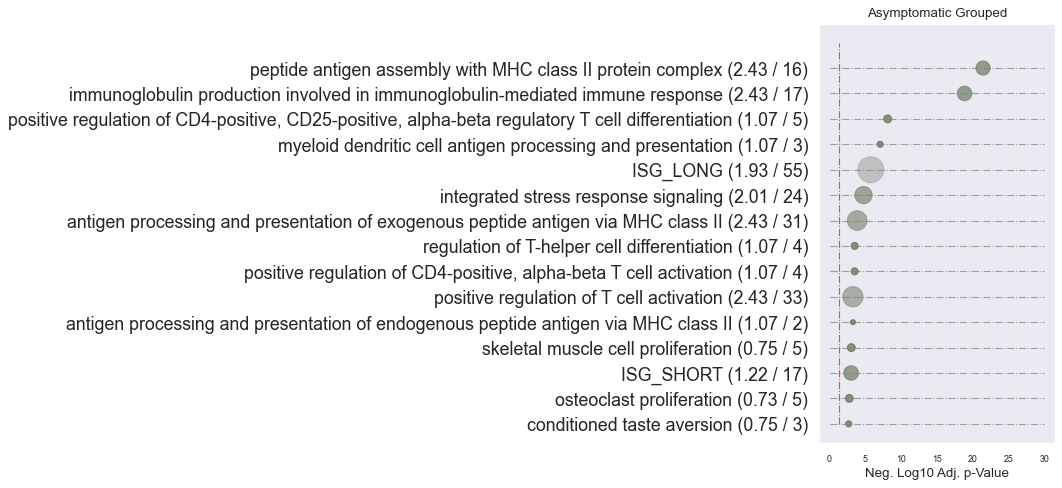

In [33]:
# Select and plot top GO pathways for asymptomatic group
selPWsAsymptGrpGO = pwScoresAsymptGrpGO[(pwScoresAsymptGrpGO["pw_coverage_adj_pval"] < 0.2)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsAsymptGrpGO)
fa.plotORAresult(selPWsAsymptGrpGO, "Asymptomatic Grouped", numResults=15, figsize=(6, 6), outfile="plots/ddiff_asympt_go")

In [34]:
# Example: string formatting test (not related to analysis)
text = "Lorem Ipsum"
f"{text:.5}"

'Lorem'

pwid                                             pwname  \
5518   GO:0002503  peptide antigen assembly with MHC class II pro...   
12314  GO:0002381  immunoglobulin production involved in immunogl...   
5520   GO:0032831  positive regulation of CD4-positive, CD25-posi...   
5516   GO:0002469  myeloid dendritic cell antigen processing and ...   
12536    ISG_LONG                                           ISG_LONG   
3401   GO:0140467               integrated stress response signaling   
3830   GO:0019886  antigen processing and presentation of exogeno...   
5522   GO:0045622        regulation of T-helper cell differentiation   
5523   GO:2000516  positive regulation of CD4-positive, alpha-bet...   
365    GO:0050870           positive regulation of T cell activation   
5517   GO:0002491  antigen processing and presentation of endogen...   
5244   GO:0014856                 skeletal muscle cell proliferation   
12535   ISG_SHORT                                          ISG_SHORT   
2062   GO:0002158                           osteoclast proliferation   
5243   GO:0001661                         conditioned taste aversion   
4774   GO:1903131                   mononuclear cell differentiation   
5245   GO:0030431                                              sleep   
4445   GO:0061052  negative regulation of cell growth involved in...   
8652   GO:0140194  negative regulation of adenylate cyclase-inhib...   
4491   GO:0001706                                 endoderm formation   

         pwFlow  pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  \
5518   2.430285       16  23.437923  292.000003                     5   
12314  2.430285       17  23.437923  292.000003                     5   
5520   1.067561        5  23.437923  292.000003                     2   
5516   1.067561        3  23.437923  292.000003                     2   
12536  1.928630       55  23.437923  292.000003                     7   
3401   2.010772       24  23.437923  292.000003                     5   
3830   2.430285       31  23.437923  292.000003                     6   
5522   1.067561        4  23.437923  292.000003                     2   
5523   1.067561        4  23.437923  292.000003                     3   
365    2.430285       33  23.437923  292.000003                     5   
5517   1.067561        2  23.437923  292.000003                     2   
5244   0.752000        5  23.437923  292.000003                     1   
12535  1.216680       17  23.437923  292.000003                     3   
2062   0.728373        5  23.437923  292.000003                     1   
5243   0.752000        3  23.437923  292.000003                     1   
4774   0.752000        3  23.437923  292.000003                     1   
5245   0.752000       11  23.437923  292.000003                     1   
4445   0.732000       11  23.437923  292.000003                     1   
8652   0.732000        1  23.437923  292.000003                     1   
4491   0.851068       13  23.437923  292.000003                     2   

       pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
5518      0.151893        0.103690       0.015750           10.542598   
12314     0.142958        0.103690       0.014823            9.899078   
5520      0.213512        0.045548       0.009725            6.952964   
5516      0.355854        0.045548       0.016209            6.559691   
12536     0.035066        0.082287       0.002885            6.059911   
3401      0.083782        0.085791       0.007188            5.637037   
3830      0.078396        0.103690       0.008129            5.249128   
5522      0.266890        0.045548       0.012156            5.049664   
5523      0.266890        0.045548       0.012156            5.049664   
365       0.073645        0.103690       0.007636            4.906924   
5517      0.533780        0.045548       0.024313            4.902773   
5244      0.150400        0.032085       0.004826            4.784032   
12535     0.07156

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(15, 14)


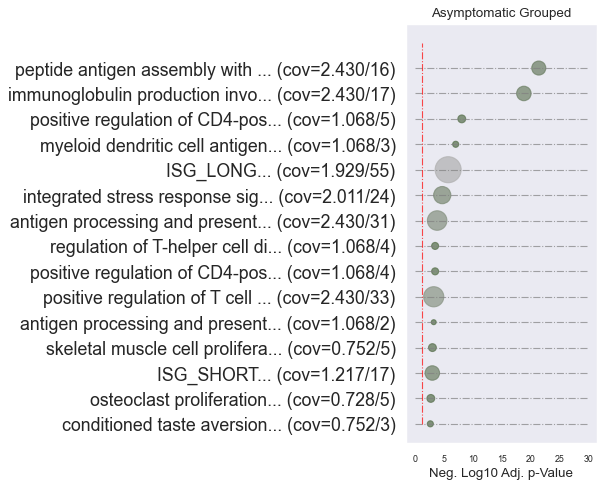

In [35]:
# Plot top GO pathways for asymptomatic group with custom entry formatting
selPWsAsymptGrpGO = pwScoresAsymptGrpGO[(pwScoresAsymptGrpGO["pw_coverage_adj_pval"] < 0.2)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsAsymptGrpGO)
fa.plotORAresult(selPWsAsymptGrpGO, "Asymptomatic Grouped", numResults=15, figsize=(4,6), outfile="plots/ddiff_asympt_go2", entryformat="{x:.30}...{sep}(cov={z:.3f}/{s})")

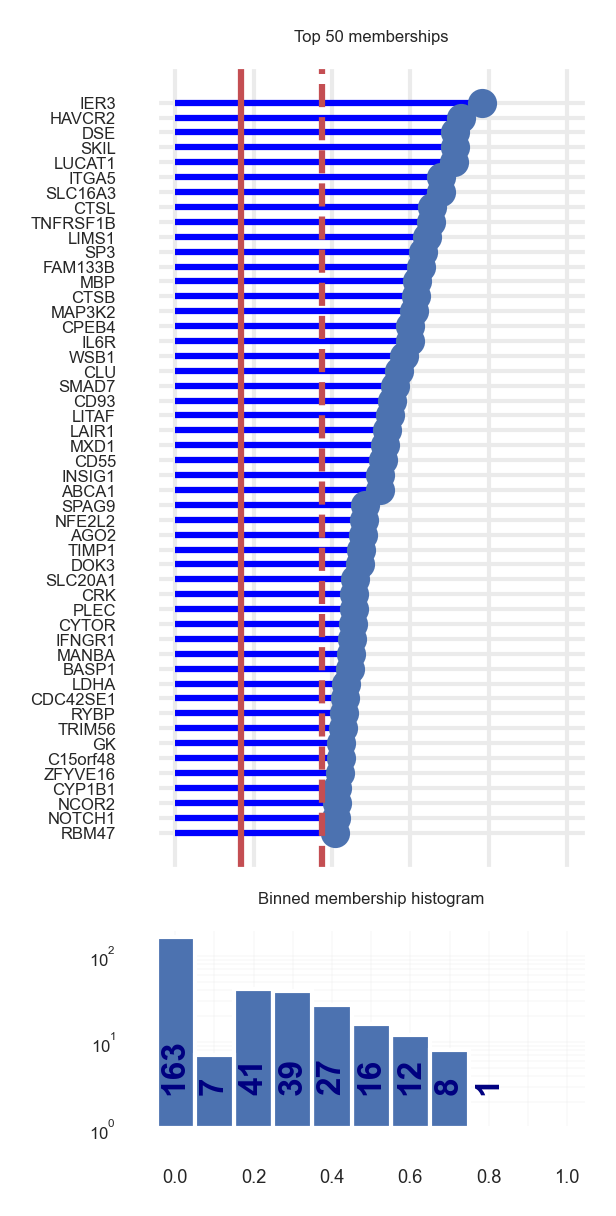

In [36]:
# Plot gene memberships for symptomatic pattern edges
memdf,_,_ = fa.plot_flow_memberships(relEdgesSympt, n_genes=50, figsize=(2,4), outfile="plots/sympt_pattern_genememberships")

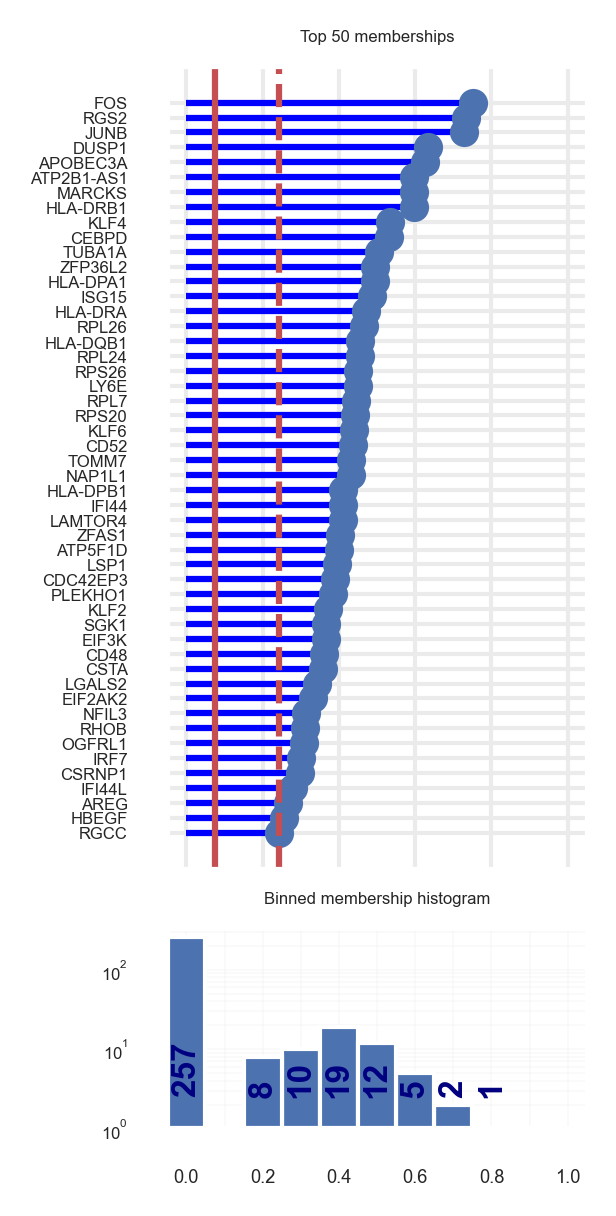

In [37]:
# Plot gene memberships for asymptomatic pattern edges
memdf,_,_ = fa.plot_flow_memberships(relEdgesAsympt, n_genes=50, figsize=(2,4), outfile="plots/asympt_patterN_genememberships")

pwid                                             pwname    pwFlow  \
4332  GO:0010614  negative regulation of cardiac muscle hypertrophy  1.403470   
2374  GO:0034616             response to laminar fluid shear stress  1.083000   
1130  GO:0046718                         viral entry into host cell  2.873173   
7558  GO:1902339  positive regulation of apoptotic process invol...  1.403470   
7557  GO:0003332  negative regulation of extracellular matrix co...  1.403470   
6042  GO:0150077           regulation of neuroinflammatory response  0.940523   
6984  GO:0003176                           aortic valve development  0.993774   
6288  GO:0097067      cellular response to thyroid hormone stimulus  1.269038   
2495  GO:1905907    negative regulation of amyloid fibril formation  0.965596   
868   GO:1901224     positive regulation of NIK/NF-kappaB signaling  2.141188   
472   GO:0032760  positive regulation of tumor necrosis factor p...  2.340994   
2667  GO:0071498            cellular response to fluid shear stress  0.936828   
4299  GO:0002281  macrophage activation involved in immune response  1.000402   
2371  GO:0030514       negative regulation of BMP signaling pathway  1.683696   
2995  GO:0002726  positive regulation of T cell cytokine production  0.781775   
5847  GO:0061419  positive regulation of transcription from RNA ...  0.793439   
176   GO:0071222            cellular response to lipopolysaccharide  3.418602   
2067  GO:0033209   tumor necrosis factor-mediated signaling pathway  1.636046   
947   GO:0032732    positive regulation of interleukin-1 production  0.728331   
2030  GO:0048844                               artery morphogenesis  1.653981   

      pwGenes  allPwFlow  allPwGenes  pw_gene_intersection  pw_coverage  \
4332       13   52.88324  292.000003                     5     0.107959   
2374        5   52.88324  292.000003                     2     0.216600   
1130      101   52.88324  292.000003                     7     0.028447   
7558        3   52.88324  292.000003                     3     0.467823   
7557        4   52.88324  292.000003                     3     0.350868   
6042       11   52.88324  292.000003                     3     0.085502   
6984        5   52.88324  292.000003                     2     0.198755   
6288       16   52.88324  292.000003                     2     0.079315   
2495       13   52.88324  292.000003                     2     0.074277   
868        66   52.88324  292.000003                     7     0.032442   
472       101   52.88324  292.000003                     6     0.023178   
2667       13   52.88324  292.000003                     4     0.072064   
4299       14   52.88324  292.000003                     2     0.071457   
2371       54   52.88324  292.000003                     4     0.031180   
2995       11   52.88324  292.000003                     2     0.071070   
5847        5   52.88324  292.000003                     2     0.158688   
176       163   52.88324  292.000003                    13     0.020973   
2067       55   52.88324  292.000003                     3     0.029746   
947        11   52.88324  292.000003                     1     0.066212   
2030       25   52.88324  292.000003                     4     0.066159   

      genes_coverage  mean_coverage  pw_coverage_zscore  pw_coverage_pval  \
4332        0.026539       0.002865            5.797814      3.359246e-09   
2374        0.020479       0.004436            4.809798      7.554134e-07   
1130        0.054331       0.001546            4.828559      6.876231e-07   
7558        0.026539       0.012416            4.458775      4.121466e-06   
7557        0.026539       0.009312            4.482473      3.689150e-06   
6042        0.017785       0.001521            4.398067      5.460958e-06   
6984        0.018792       0.003735            4.335555      7.269632e-06   
6288        0.023997       0.001903            4.012422      3.004944e-05   
2495        0.018259       0.001356      

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(15, 14)


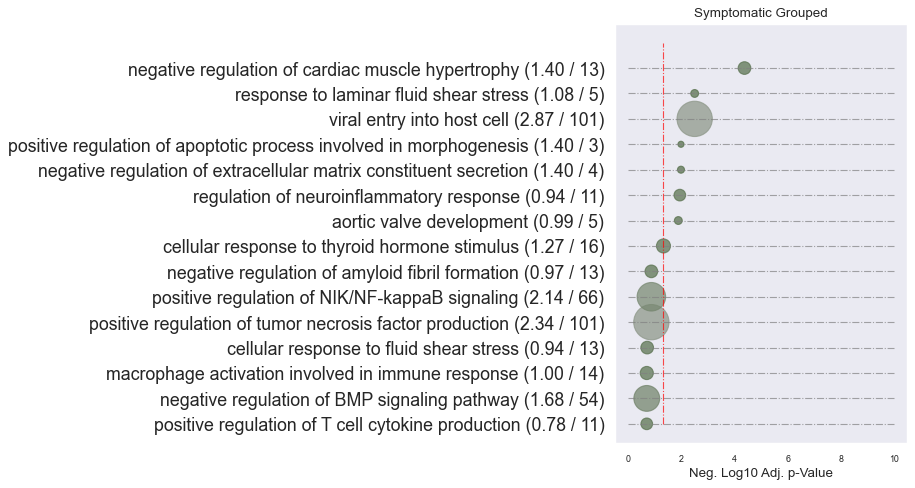

In [38]:
# Select and plot top GO pathways for symptomatic group
selPWsSymptGrpGO = pwScoresSymptGrpGO[(pwScoresSymptGrpGO["pw_coverage_adj_pval"] < 1)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsSymptGrpGO)
fa.plotORAresult(selPWsSymptGrpGO, "Symptomatic Grouped", numResults=15, figsize=(6,6), outfile="plots/ddiff_sympt_go")

In [39]:
list(dict.fromkeys(x for v in fa.levelOrder.values() for x in v))

['ASYMPT', 'asympt', 'nodiff', 'sympt', 'SYMPT']

Loading pathways from go_human.bp.gmt
Identified 12535 pathways
Adding title Viral entry into host cell


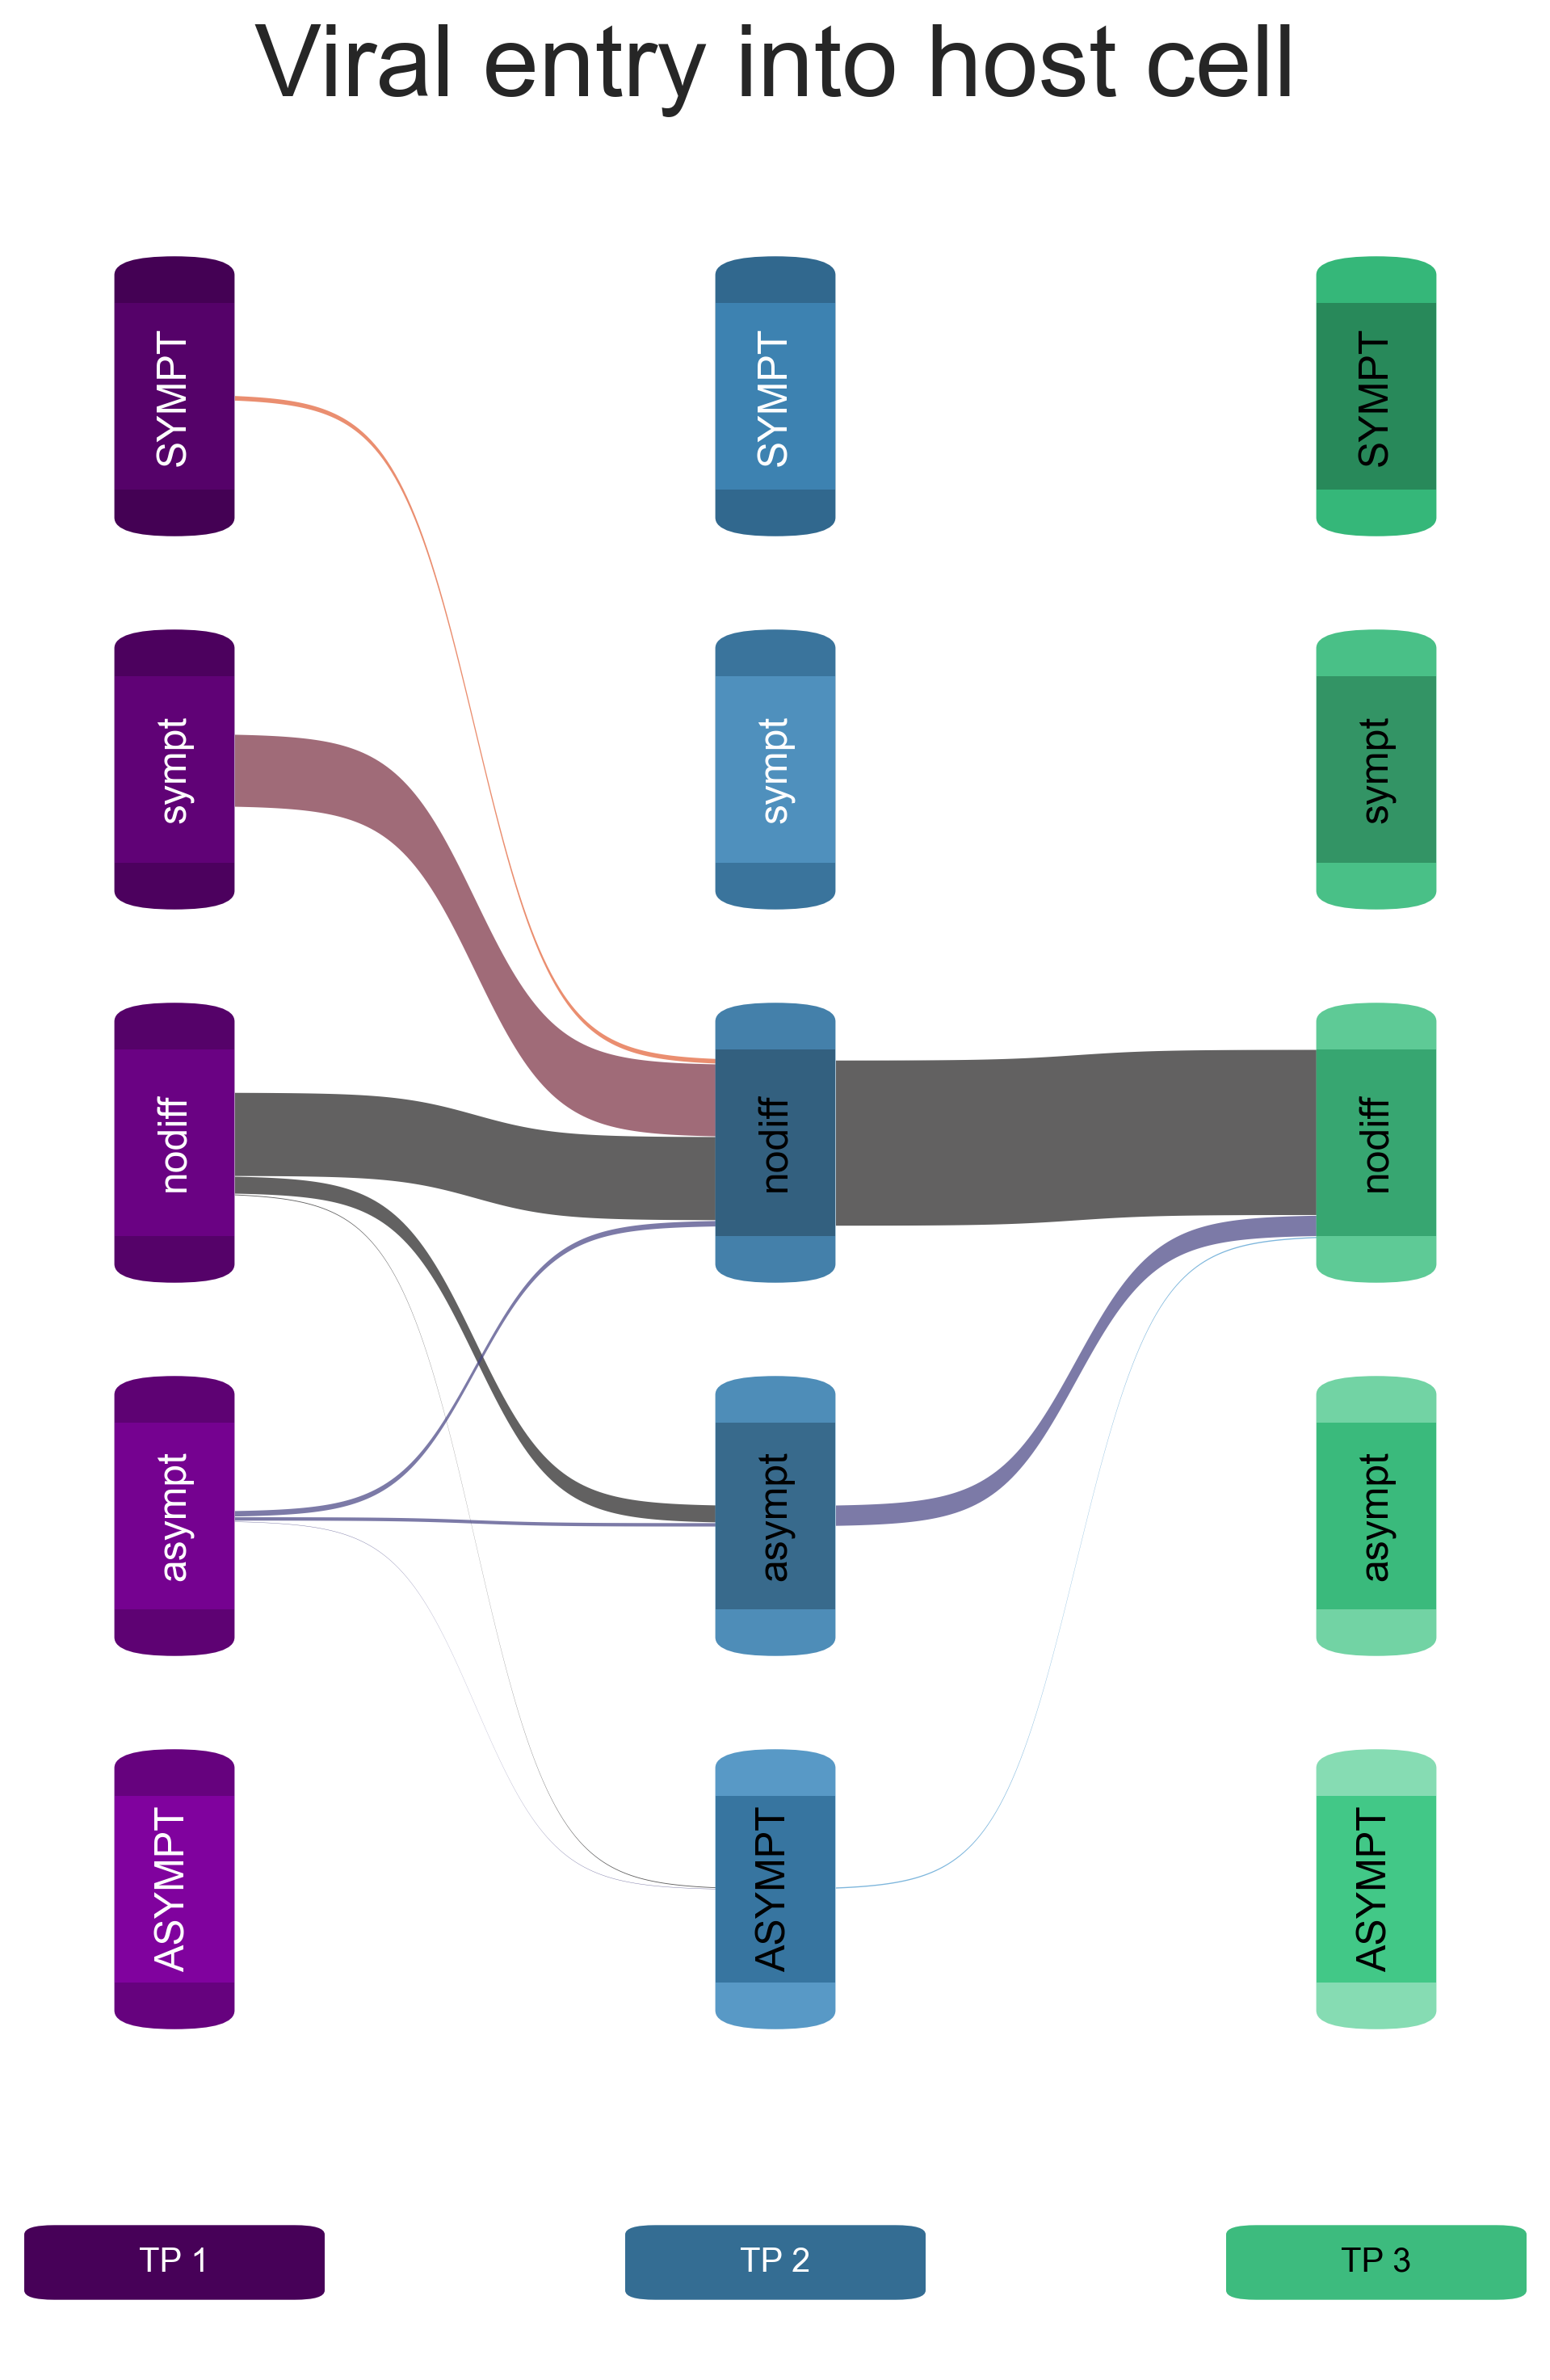

Adding title Peptide antigen assembly ...


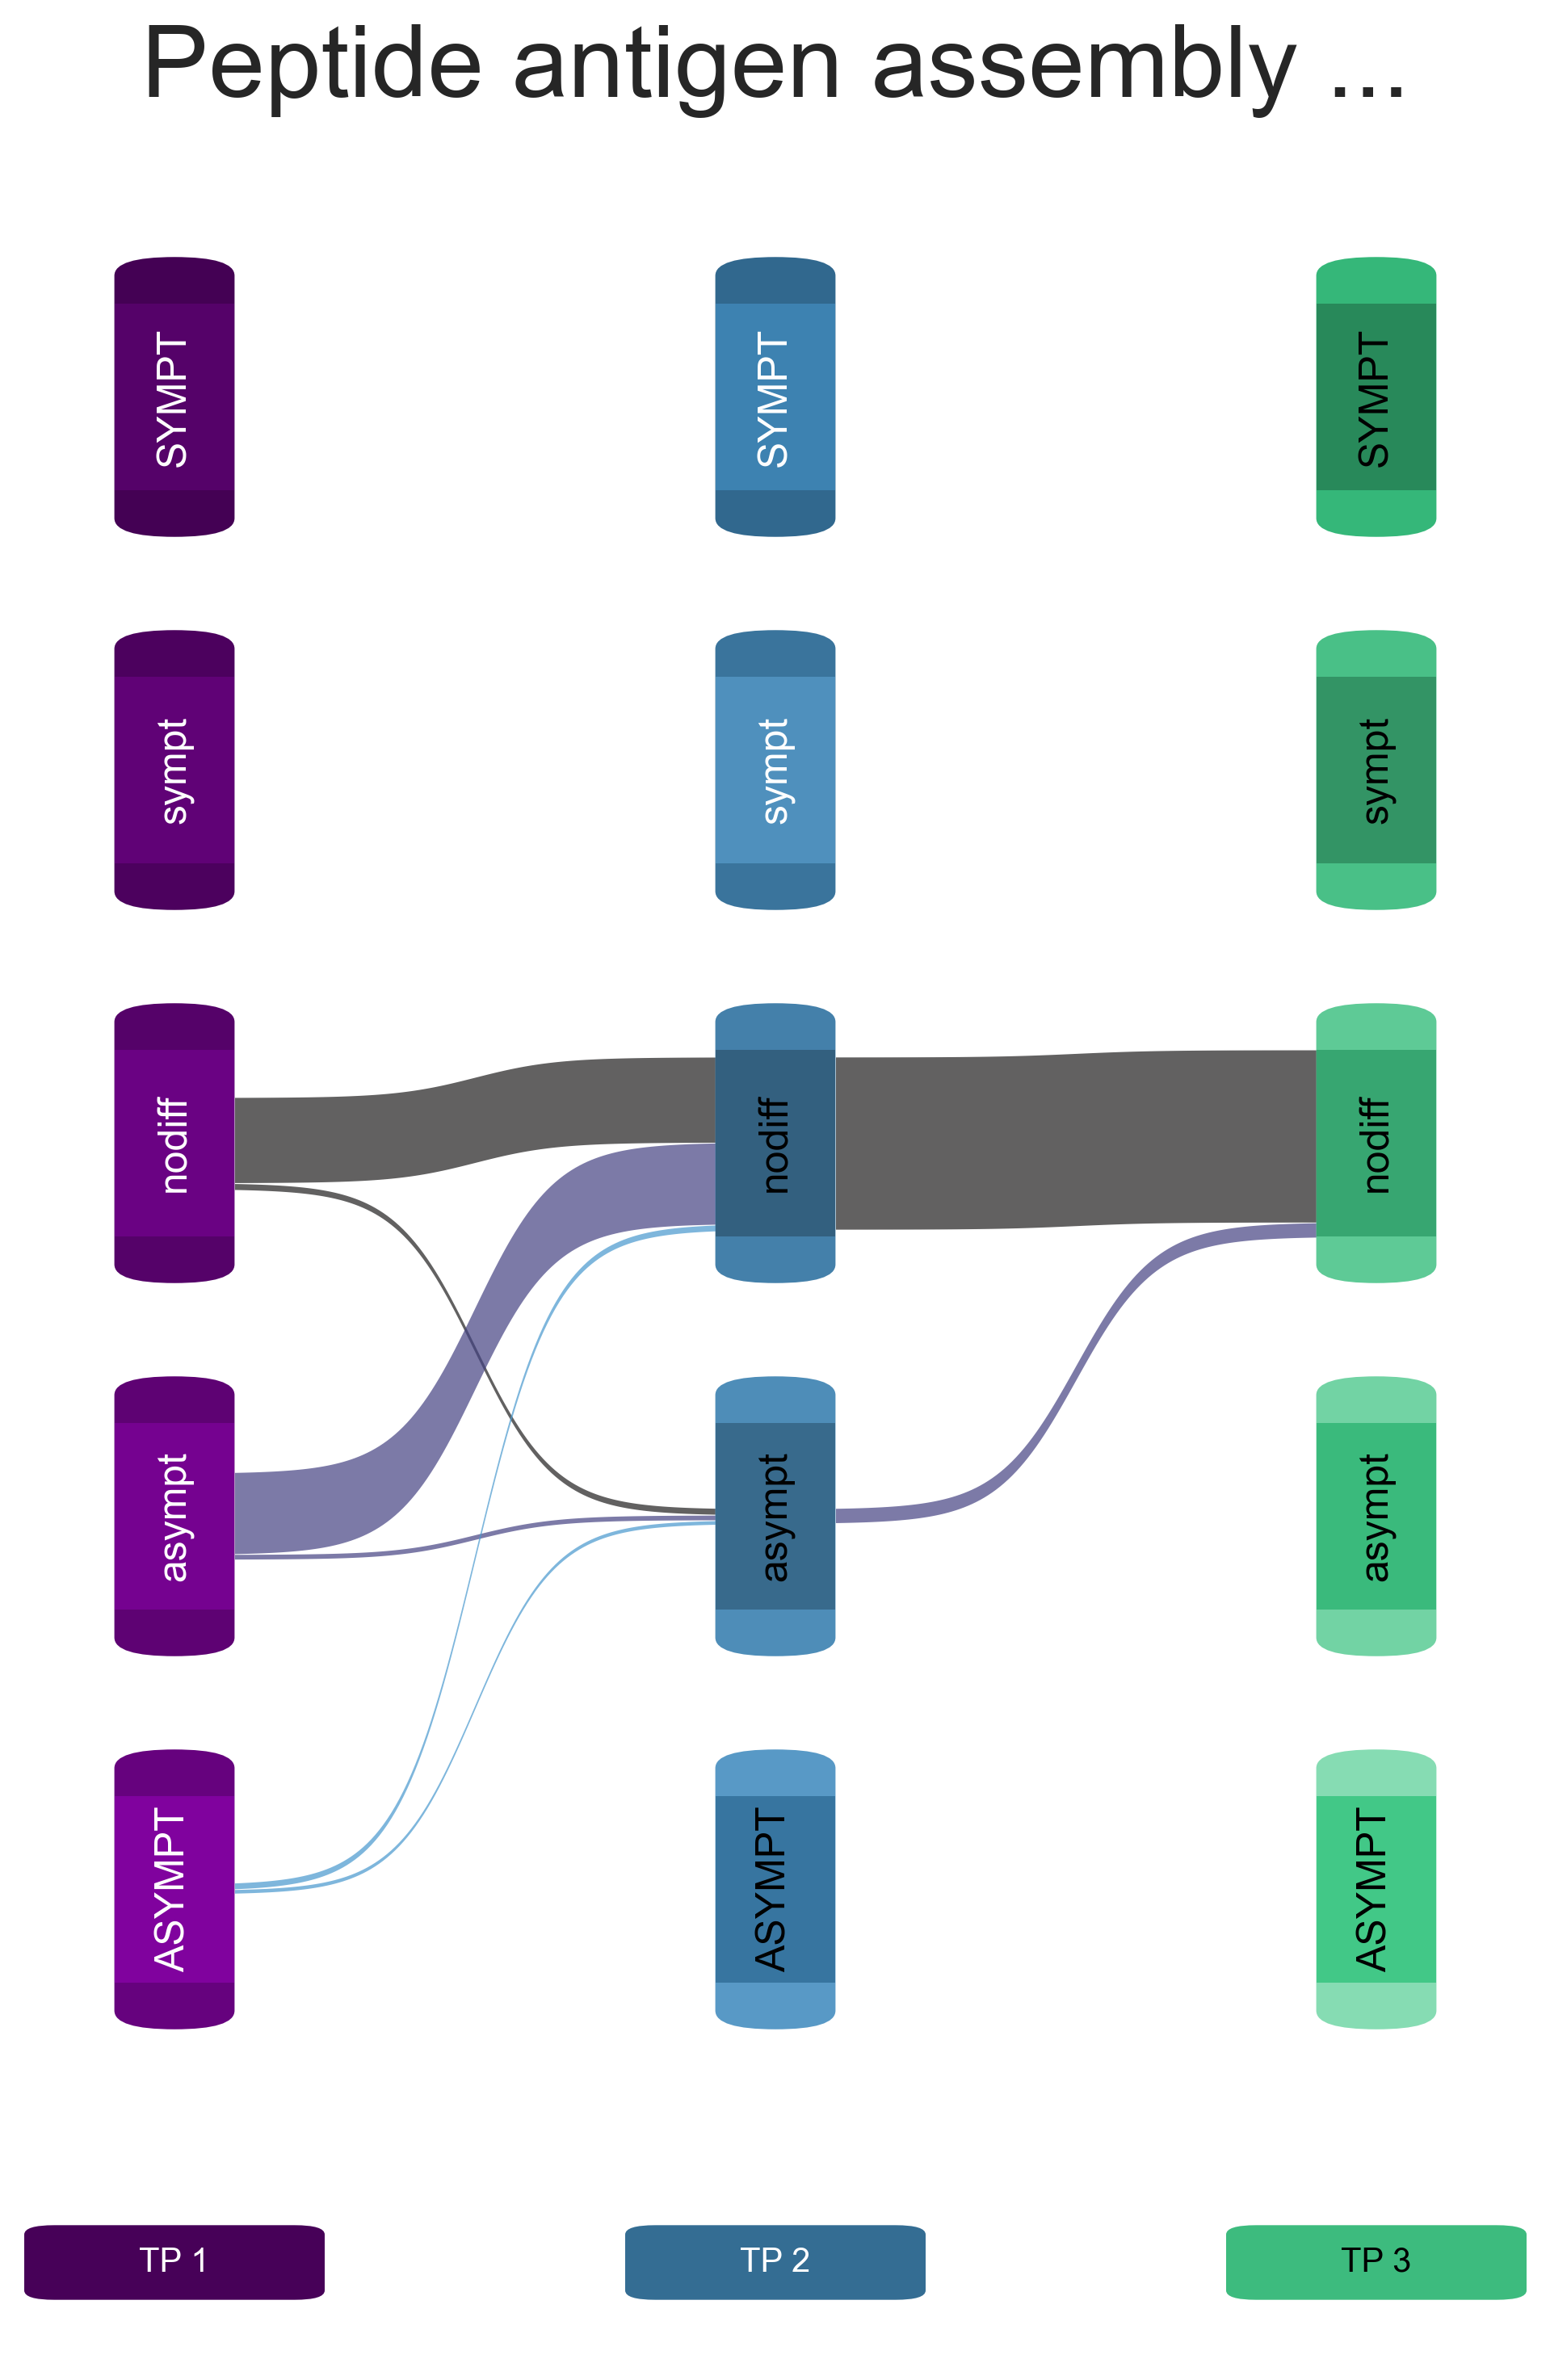

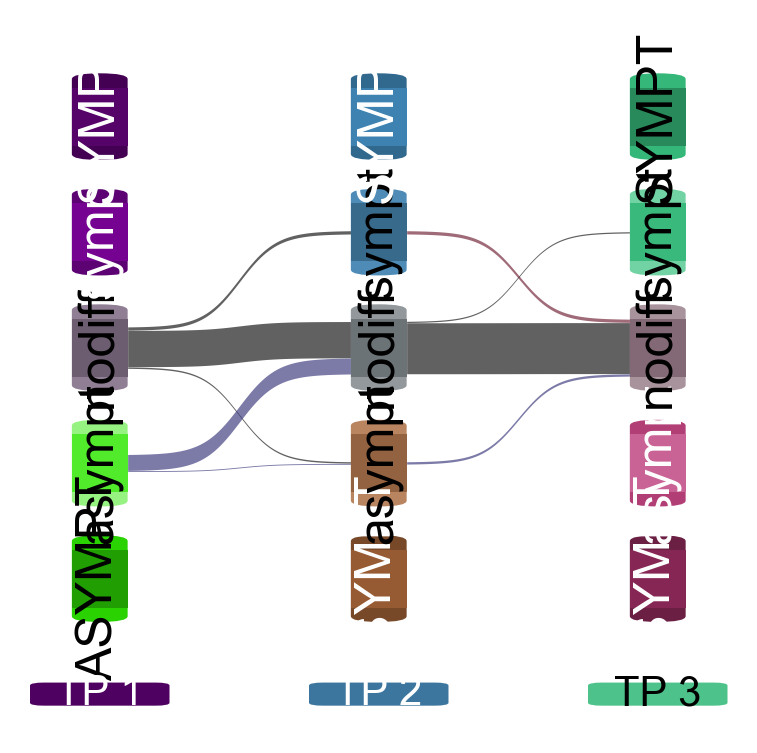

In [40]:
# Example: plot flows for a specific GO pathway and for ISG genes
pw_file="go_human.bp.gmt"

pathways = fa.get_pathways(pw_file,to_upper=False)
k="GO:0002381"
k="GO:0002503"
k="GO:0046718"
pw_genes=pathways[k][1]

fa.plot_flows(genes=pathways["GO:0046718"][1], seriesColors=sc, figsize=(8,12),sns_palette="icefire",title="Viral entry into host cell",outfile="plots/ddiff_flows_go_0046718")
fa.plot_flows(genes=pathways["GO:0002503"][1], seriesColors=sc, figsize=(8,12),sns_palette="icefire",title="Peptide antigen assembly ...", outfile="plots/ddiff_flows_go_0002503")

fa.plot_flows(genes=isgListLong, seriesColors=sc, figsize=(3,3),  colorMode="diverging")